# [Code] Enhancing Short Term AQI Predictions with Location & Meteorological Data
Stanford STATS 207 Final Project 

Authors: Kushagra Gupta & Quentin Hsu

Overleaf Doc: https://www.overleaf.com/read/yrjpxxzpyqfv

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 28.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from functools import reduce
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pmdarima import auto_arima
from pmdarima.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import normaltest
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.preprocessing import LogEndogTransformer
from pmdarima.utils import tsdisplay
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn import metrics
from timeit import default_timer as timer
from math import radians, sin, cos, asin, acos, sqrt, atan2, degrees, floor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data

In [ ]:
def make_data(name, start_year, end_year, verbose = True):
    total_data = pd.DataFrame()
    n_rows = 0
    for i in range(end_year, start_year-1, -1):
        data_name = 'drive/Shareddrives/STATS_207/data/' + name + str(i) + '.csv'
        data_daily = pd.read_csv(data_name)
        cali_data = data_daily[data_daily['State Name'] == 'California']
        if verbose:
            print(i, cali_data.shape)
            print(cali_data.isnull().values.any())
        n_rows += cali_data.shape[0]
        total_data = total_data.append(cali_data)
    return total_data

In [ ]:
def make_site_num(df):
    foo = df['Defining Site'].str.split("-")
    df['Site Num'] = [int(x[2]) for x in foo]
    return df

In [ ]:
## Pick data from California

total_rhdp = make_data('daily_RH_DP_', 2016, 2020, False)
total_rhdp['Date Local'] = pd.to_datetime(total_rhdp['Date Local'])
#total_rhdp.head()
cali_rhdp = total_rhdp[total_rhdp['State Name'] == 'California']
rhdp_county = np.unique(total_rhdp['County Name'])

total_temp = make_data('daily_TEMP_', 2016, 2020, False)
total_temp['Date Local'] = pd.to_datetime(total_temp['Date Local'])
#total_temp.head()
cali_temp = total_temp[total_temp['State Name'] == 'California']
temp_county = np.unique(total_temp['County Name'])

total_wind = make_data('daily_WIND_', 2016, 2020, False)
total_wind['Date Local'] = pd.to_datetime(total_wind['Date Local'])
#total_wind.head()
cali_wind = total_wind[total_wind['State Name'] == 'California']
cali_wind_direction = cali_wind[cali_wind['Parameter Name'] == 'Wind Direction - Resultant']
cali_wind_speed = cali_wind[cali_wind['Parameter Name'] == 'Wind Speed - Resultant']
wind_county = np.unique(total_wind['County Name'])
wind_direction_county = np.unique(total_wind[total_wind['Parameter Name'] == 'Wind Direction - Resultant']['County Name'])
wind_speed_county = np.unique(total_wind[total_wind['Parameter Name'] == 'Wind Speed - Resultant']['County Name'])

total_aqi = make_data('daily_aqi_by_county_', 2016, 2020, False)
total_aqi.rename(columns = {'county Name':'County Name', 'Date':'Date Local'}, inplace = True)
total_aqi = make_site_num(total_aqi)
total_aqi['Date Local'] = pd.to_datetime(total_aqi['Date Local'])
#total_aqi.head()
cali_aqi = total_aqi[total_aqi['State Name'] == 'California']
aqi_county = np.unique(total_aqi['County Name'])

## Distance Calculations and Wind Projection

In [ ]:
def haversine(lat1, lon1, lat2, lon2):

    R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    return R * c

def angleFromCoordinate(lat1, long1, lat2, long2):

    dLon = (long2 - long1)

    y = sin(dLon) * cos(lat2)
    x = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dLon)

    brng = atan2(y, x)

    brng = degrees(brng)
    brng = (brng + 360) % 360
    brng = 360 - brng

    return brng

In [ ]:
data_path = 'drive/Shareddrives/STATS_207/data/'
sites_df = pd.read_csv(data_path + '/aqs_sites.csv')
ca_sites = sites_df[sites_df['State Name'] == 'California'].groupby(['County Code', 'County Name'])[['Latitude', 'Longitude']].mean().reset_index()
ca_sites['dist'] = ca_sites.apply(lambda row:
        haversine(
          row.Latitude, 
          row.Longitude,
          ca_sites[ca_sites['County Name'] == 'Santa Clara']['Latitude'], 
          ca_sites[ca_sites['County Name'] == 'Santa Clara']['Longitude']),
      axis=1
)
ca_sites['bearing'] = ca_sites.apply(lambda row:
        angleFromCoordinate(
          row.Latitude, 
          row.Longitude,
          ca_sites[ca_sites['County Name'] == 'Santa Clara']['Latitude'], 
          ca_sites[ca_sites['County Name'] == 'Santa Clara']['Longitude']),
      axis=1
)
close_counties = ca_sites[ca_sites.dist < 100]['County Name']

In [ ]:
cali_wind_proj = total_wind[total_wind['State Name'] == 'California'].groupby( ['County Name', 'Site Num', 'Parameter Name', 'Date Local'])['Arithmetic Mean'].mean().reset_index().pivot(index =  ['County Name', 'Site Num', 'Date Local'], columns = 'Parameter Name', values = 'Arithmetic Mean').reset_index()
cali_wind_proj = cali_wind_proj.merge(ca_sites, on='County Name', how='left')
# How much distance in the direction of Santa Clara the wind travelled in a day
cali_wind_proj['wind_projection'] = cali_wind_proj['Wind Speed - Resultant']*1.151*24/np.cos(cali_wind_proj['Wind Direction - Resultant'] - cali_wind_proj['bearing'])


In [ ]:
# Counties avalaible for all out data
np.intersect1d(rhdp_county, 
                           np.intersect1d(aqi_county,
                                             np.intersect1d(wind_county, temp_county)))

array(['Amador', 'Butte', 'Calaveras', 'Colusa', 'El Dorado', 'Fresno',
       'Glenn', 'Imperial', 'Inyo', 'Kern', 'Los Angeles', 'Madera',
       'Mariposa', 'Mono', 'Orange', 'Placer', 'Riverside', 'Sacramento',
       'San Benito', 'San Bernardino', 'San Diego', 'San Joaquin',
       'San Luis Obispo', 'Santa Barbara', 'Santa Clara', 'Shasta',
       'Stanislaus', 'Sutter', 'Tehama', 'Tulare', 'Tuolumne', 'Ventura',
       'Yolo'], dtype=object)

## Aggregate Sites to County Level

In [ ]:
# Take the mean across sites in a county

cali_aqi = cali_aqi[['County Name', 'Date Local', 'AQI']]
cali_aqi = cali_aqi.groupby(['County Name', 'Date Local'], as_index=False).mean()

cali_temp = cali_temp[['County Name', 'Date Local', 'Arithmetic Mean']]
cali_temp.columns = ['County Name', 'Date Local', 'Arithmetic Mean temp']
cali_temp = cali_temp.groupby(['County Name', 'Date Local'], as_index=False).mean()

cali_rhdp = cali_rhdp[['County Name', 'Date Local', 'Arithmetic Mean']]
cali_rhdp.columns = ['County Name', 'Date Local', 'Arithmetic Mean rhdp']
cali_rhdp = cali_rhdp.groupby(['County Name', 'Date Local'], as_index=False).mean()

cali_wind = cali_wind[['County Name', 'Date Local', 'Arithmetic Mean']]
cali_wind.columns = ['County Name', 'Date Local', 'Arithmetic Mean wind']
cali_wind = cali_wind.groupby(['County Name', 'Date Local'], as_index=False).mean()

cali_wind_direction = cali_wind_direction[['County Name', 'Date Local', 'Arithmetic Mean']]
cali_wind_direction.columns = ['County Name', 'Date Local', 'Arithmetic Mean wind_direction']
cali_wind_direction = cali_wind_direction.groupby(['County Name', 'Date Local'], as_index=False).mean()

cali_wind_speed = cali_wind_speed[['County Name', 'Date Local', 'Arithmetic Mean']]
cali_wind_speed.columns = ['County Name', 'Date Local', 'Arithmetic Mean wind_speed']
cali_wind_speed = cali_wind_speed.groupby(['County Name', 'Date Local'], as_index=False).mean()

cali_wind_proj = cali_wind_proj[['County Name', 'Date Local', 'wind_projection']]
cali_wind_proj = cali_wind_proj.groupby(['County Name', 'Date Local'], as_index=False).mean()
cali_wind_proj.head()

,County Name,Date Local,wind_projection
0,Amador,2016-01-01,217.355411
1,Amador,2016-01-02,-113.141696
2,Amador,2016-01-03,31.406466
3,Amador,2016-01-04,34.993314
4,Amador,2016-01-05,1044.067531


## Combine Time Series Data

In [ ]:
# Join the AQI and meteorology time series
all_dfs = [cali_aqi, 
           cali_temp, 
          cali_rhdp,
          cali_wind_speed,
          cali_wind_direction,
          cali_wind_proj]
df_final = reduce(lambda left,right: pd.merge(left,right,on=('County Name', 'Date Local')), all_dfs)
start_date = pd.to_datetime('2016-06-01')
end_date = df_final['Date Local'].max()
print(start_date, end_date)

2016-06-01 00:00:00 2020-12-31 00:00:00


## County Data

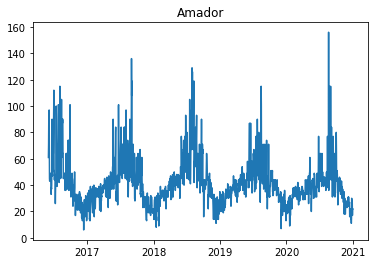

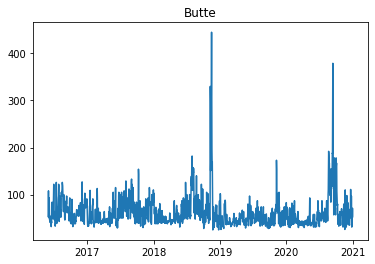

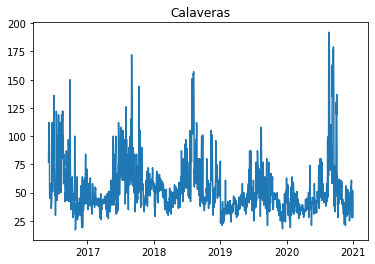

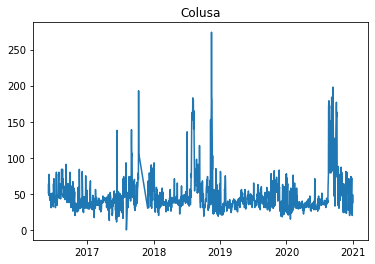

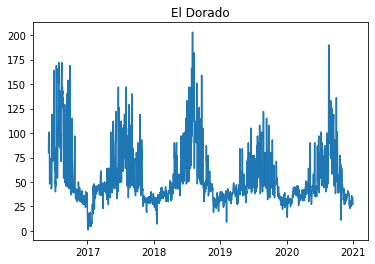

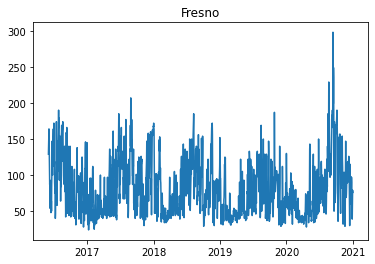

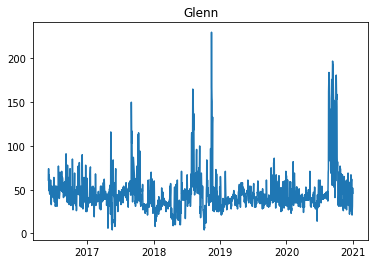

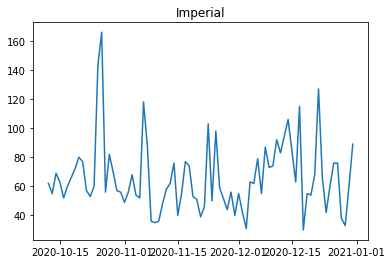

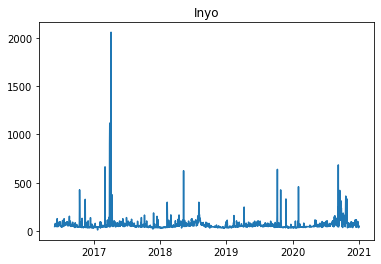

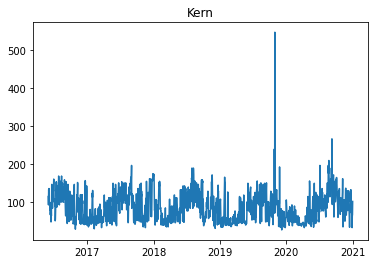

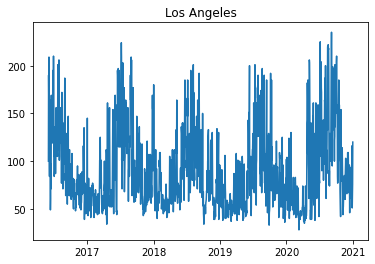

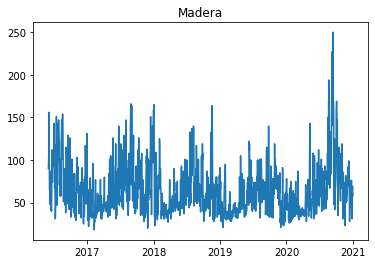

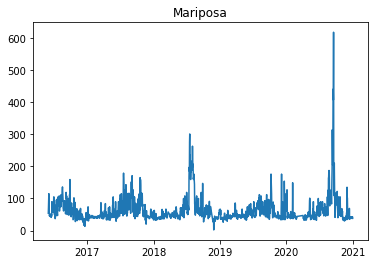

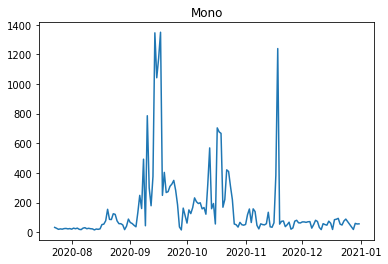

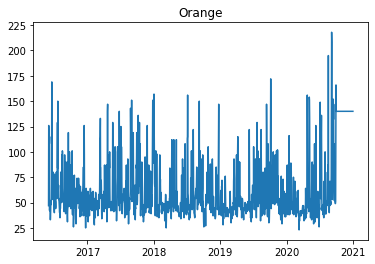

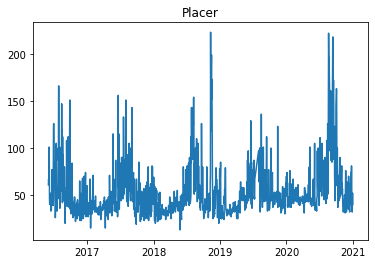

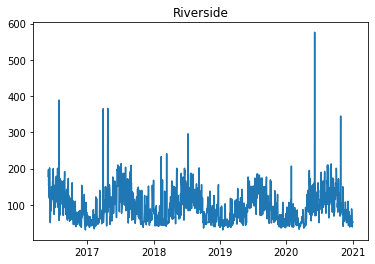

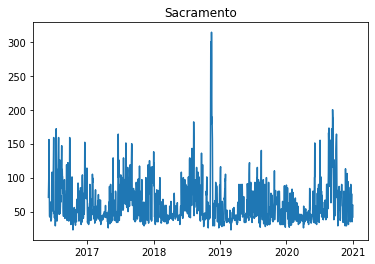

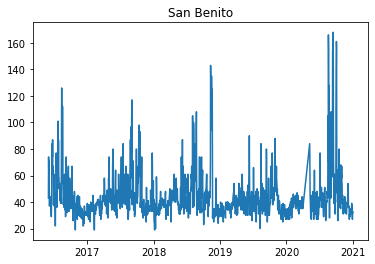

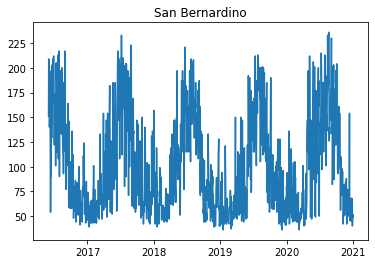

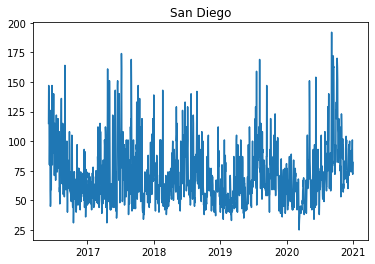

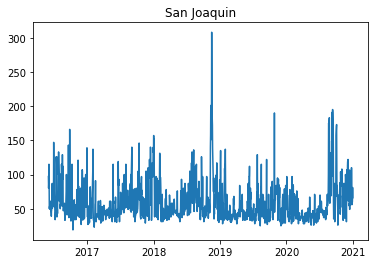

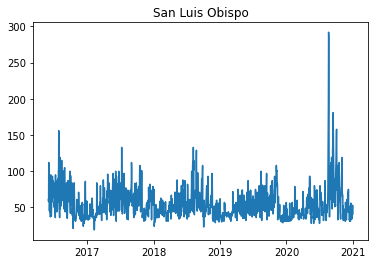

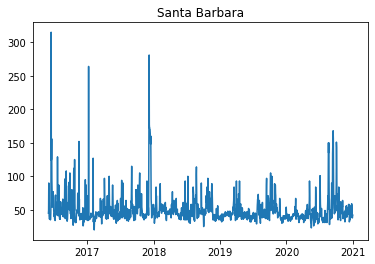

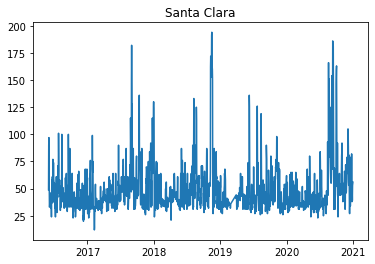

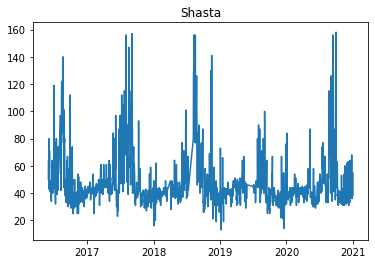

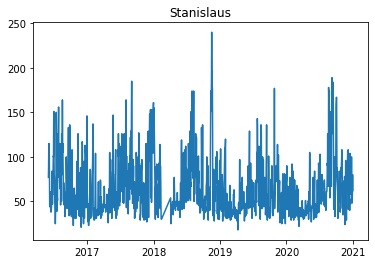

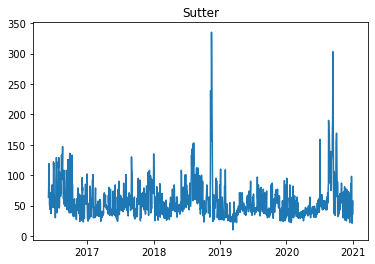

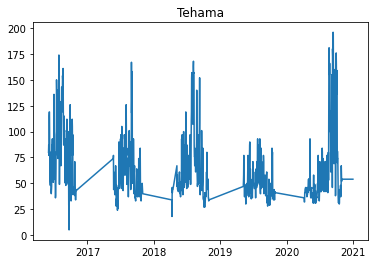

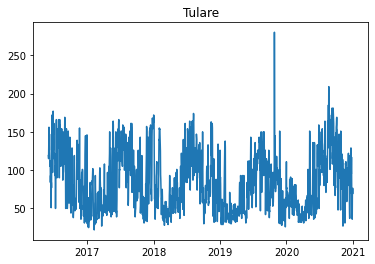

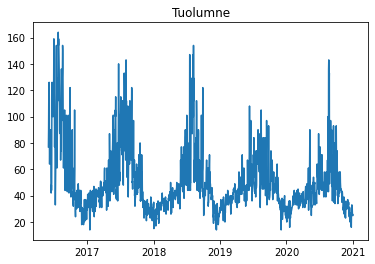

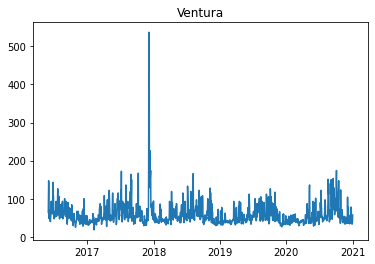

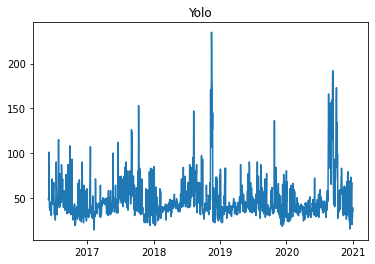

In [ ]:
# A dictionary of county name vs the time series for that county. This step also interpolates for the missing dates
county_dict = {}
counties = np.unique(df_final['County Name'])
for county in counties:
    county_df = df_final[df_final['County Name'] == county]
    idx = pd.date_range(start_date, end_date)
    county_df.set_index('Date Local', inplace = True)
    county_df = county_df.reindex(idx)
    county_df = county_df.interpolate()
    county_df['County Name'] = county
    plt.plot(county_df['AQI'])
    plt.title(county)
    plt.show()
    county_dict[county] = county_df

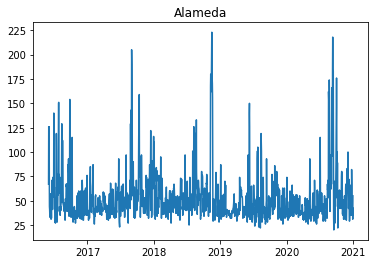

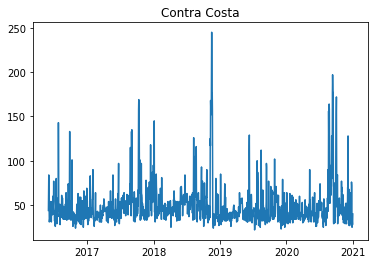

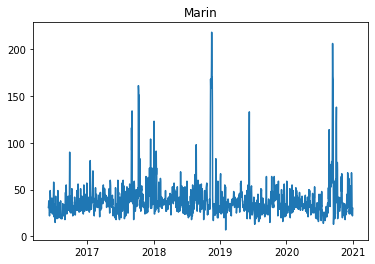

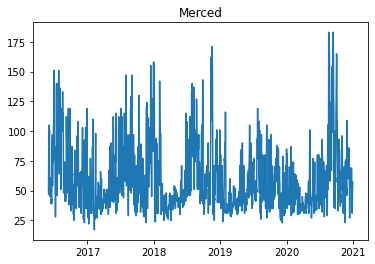

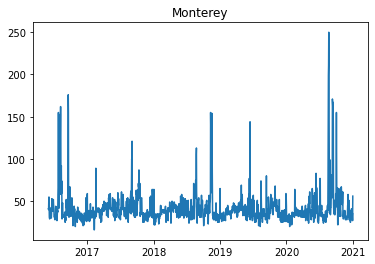

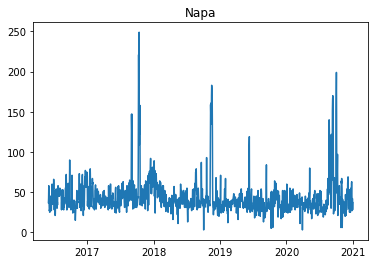

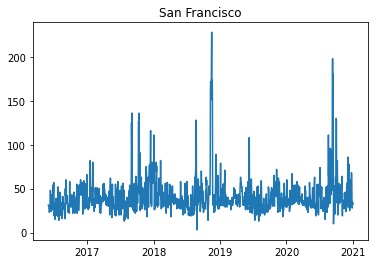

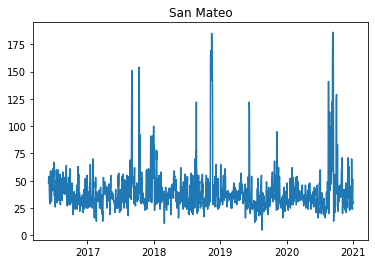

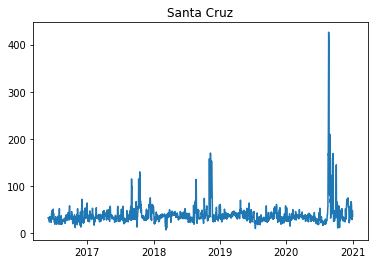

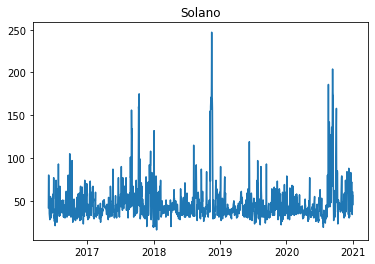

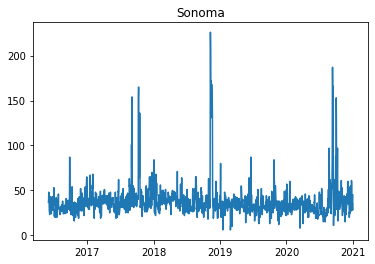

In [ ]:
for county in close_counties:
    if county not in county_dict:
        county_df = cali_aqi[cali_aqi['County Name'] == county]
        idx = pd.date_range(start_date, end_date)
        county_df.set_index('Date Local', inplace = True)
        county_df = county_df.reindex(idx)
        county_df = county_df.interpolate()
        county_df['County Name'] = county
        plt.plot(county_df['AQI'])
        plt.title(county)
        plt.show()
        county_dict[county] = county_df

In [ ]:
counties_to_use = np.intersect1d(counties, close_counties)
len(counties_to_use)


8

In [ ]:
aqi = county_dict['Santa Clara'].AQI

In [ ]:
close_counties = ca_sites[ca_sites.dist < 100]['County Name']

In [ ]:
counties_to_use = np.intersect1d(counties, close_counties)

# Cross Validation

This function returns a 2 dimensional list of indexes to use for splitting dataframes into blocks of train and test.

The structure would be cv_idx[b][t] where b is the index of the block and t is 0 for train and 1 for test.

In [ ]:
from math import floor

def cv_rolling_split(df, train_size, test_size, step_size):
    total_size = len(df)
    n_blocks = floor(total_size/step_size)
    
    cv_idx = []
    
    for b in range(0,n_blocks):
        start_idx = b*step_size

        # skip the block if end of block exceeds our dataframe size
        if(start_idx + train_size + test_size > total_size):
          break

        tmp_list = []
        tmp_list.append(list(range(start_idx,(start_idx+train_size))))
        tmp_list.append(list(range((start_idx+train_size),(start_idx+train_size+test_size))))
        cv_idx.append(tmp_list)
    
    return cv_idx

In [ ]:
# We didn't end up using this version
def cv_split(df, blocks, test_size):
    total_size = len(df)
    block_size = floor(total_size/blocks)
    train_size = block_size - test_size
    
    cv_idx = []
    
    for b in range(0,blocks):
        start_idx = b*block_size
        tmp_list = []
        tmp_list.append(list(range(start_idx,(start_idx+train_size))))
        tmp_list.append(list(range((start_idx+train_size),(start_idx+train_size+test_size))))
        cv_idx.append(tmp_list)
    
    return cv_idx

In [ ]:
# We didn't end up using this version
def cv_increm_split(df, init_train_size, test_size, step_size):
    total_size = len(df)
    n_blocks = floor(total_size/step_size)
    
    cv_idx = []
    
    for b in range(0,n_blocks):
        start_idx = 0
        train_size = init_train_size + b*step_size

        # skip the block if end of block exceeds our dataframe size
        if(start_idx + train_size + test_size > total_size):
          break

        tmp_list = []
        tmp_list.append(list(range(start_idx,(start_idx+train_size))))
        tmp_list.append(list(range((start_idx+train_size),(start_idx+train_size+test_size))))
        cv_idx.append(tmp_list)
    
    return cv_idx

# Carry Forward Last Observation

In [ ]:
def baseline_results(df):
    n = len(df)
    dates = df.index
    preds = np.zeros(n-1)
    rmse = list()
    pred = list()
    actual = list()
    for i in range(1,n-3,3):
        rmse.append(sqrt(mse(df.loc[df.index[i:i+3]],np.repeat(df.loc[df.index[i-1]], 3)))),
        pred.append(df.loc[df.index[i:i+3]])
        actual.append(np.repeat(df.loc[df.index[i-1]], 3))
    return np.mean(rmse)

In [ ]:
aqi = county_dict['Santa Clara'].AQI

In [ ]:
aqi_2019 = aqi[(aqi.index >= '2019-01-01') & (aqi.index <= '2020-01-01')]
aqi_wildfire = aqi[(aqi.index >= '2020-07-31') & ((aqi.index <= '2020-10-31'))]
aqi_no_wildfire = aqi[((aqi.index >= '2020-01-01') & (aqi.index < '2020-08-01')) | ((aqi.index > '2020-10-31') & (aqi.index <= '2020-12-31'))]

In [ ]:
print(baseline_results(aqi_2019))
print(baseline_results(aqi_wildfire))
print(baseline_results(aqi_no_wildfire))

12.38306625877028
29.40181459328848
13.304994317488237


# Initial Plots

In [ ]:
aqi_train, aqi_test = train_test_split(aqi, train_size=int(np.floor(aqi.shape[0]*0.8)))

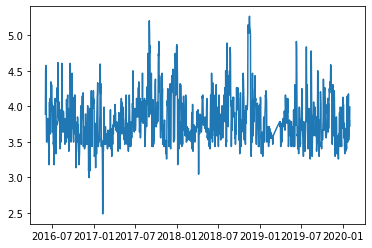

In [ ]:
plt.plot(aqi_train.index, np.log(aqi_train.values))

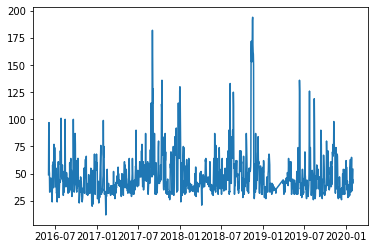

In [ ]:
plt.plot(aqi_train.index, aqi_train.values)

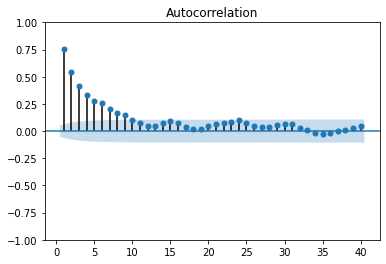

In [ ]:
sm.graphics.tsa.plot_acf(aqi_train, lags=40, zero = False)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


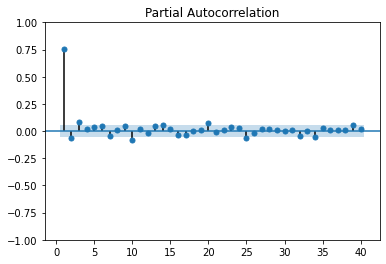

In [ ]:
sm.graphics.tsa.plot_pacf(aqi_train, lags=40, zero = False)
plt.show()

# Data Tests

## Stationarity

In [ ]:
# test for stationarity
result = adfuller(aqi_train, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.231840207837048
p-value: 4.931782724723134e-08
Critial Values:
   1%, -3.4353136835264664
Critial Values:
   5%, -2.863732068602694
Critial Values:
   10%, -2.5679370666896233


/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


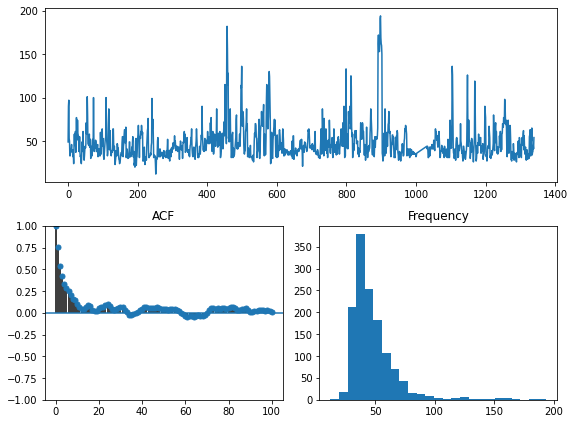

In [ ]:
tsdisplay(aqi_train, lag_max=100)

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


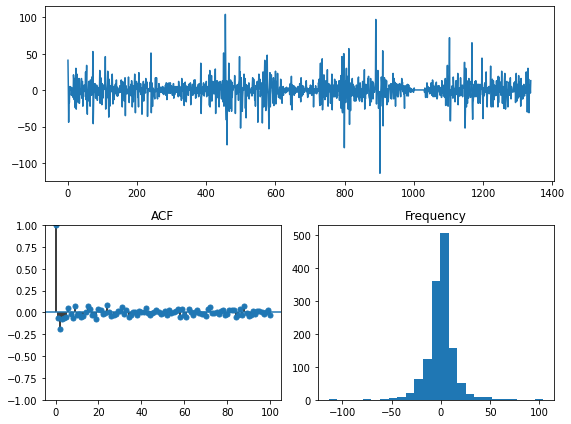

ADF Statistic: -12.3504461693822
p-value: 5.841710602823392e-23
Critial Values:
   1%, -3.4353288002925315
Critial Values:
   5%, -2.863738738939919
Critial Values:
   10%, -2.5679406189198177


In [ ]:
aqi_diff = np.diff(aqi_train)
tsdisplay(aqi_diff, lag_max=100)
result = adfuller(aqi_diff, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


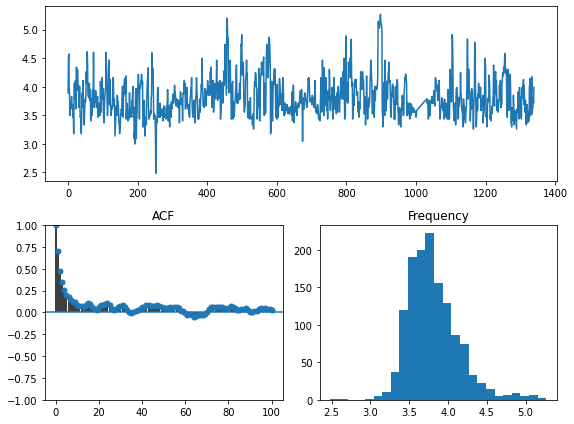

ADF Statistic: -12.93060043362975
p-value: 3.707652717020569e-24
Critial Values:
   1%, -3.435250448324718
Critial Values:
   5%, -2.8637041654378903
Critial Values:
   10%, -2.567922207159556


In [ ]:
aqi_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(aqi_train)
tsdisplay(aqi_log, lag_max=100)
result = adfuller(aqi_log, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# ARIMA

In [ ]:
def plot_forecasts(forecasts, title = "meh", figsize=(8, 12)):
    x = np.arange(aqi_train.shape[0] + forecasts.shape[0])

    fig, axes = plt.subplots(2, 1, sharex=False, figsize=figsize)

    # Plot the forecasts
    axes[0].plot(x[:aqi_train.shape[0]], aqi_train, c='b')
    axes[0].plot(x[aqi_train.shape[0]:], forecasts, c='g')
    axes[0].set_xlabel(f'Sunspots (RMSE={np.sqrt(mse(aqi_test, forecasts)):.3f})')
    axes[0].set_title(title)

    plt.tight_layout()
    plt.show()

In [ ]:
def check_stationarity(df):
    result = adfuller(df, autolag='AIC')
    if result[1] >= 0.05:
        return False
    return True

In [ ]:
def cv_rmse(df, cv_test_idx, model):
    rmse = 0
    no_runs = 0
    transform_used = "null"
    df_cv_summary = pd.DataFrame()
    batch_num = 0
    for train_idx, test_idx in cv_test_idx:
        df_train = df.iloc[train_idx]
        df_test = df.iloc[test_idx]
        transform_used = "null"
        if isinstance(df_train, pd.DataFrame):
            for col in df_train.columns:
                if check_stationarity(df_train[col]) == False:
                    transform = LogEndogTransformer(lmbda=1e-6).fit_transform(df_train[col])
                    if check_stationarity(transform) == True:
                        transform_bool = 'log'
                        df_train[col] = transform
                    else:
                        transform = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(df_train[col])
                        if check_stationarity(transform) == True:
                            transform_bool = 'box'
                            df_train[col] = transform2
                        else:
                            transform_diff = np.diff(df_train[col])
                            if check_stationarity(transform_diff) == True:
                                transform_bool = 'diff'
                                df_train[col] = np.concatenate(([df_train[col].iloc[0]], transform_diff))
                            else:
                                raise ValueError(col + ' data not stationary')
        else:
        if check_stationarity(df_train) == False:
            transform,_ = LogEndogTransformer(lmbda=1e-6).fit_transform(df_train)
            if check_stationarity(transform) == True:
                transform_used = "log"
                df_train = transform
            else:
                transform,_ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(df_train)
                if check_stationarity(transform) == True:
                    transform_used = "box"
                    df_train = transform
                else:
                    transform_bool = 1
                    transform_diff = np.diff(df_train)
                    if check_stationarity(transform_diff) == True:
                        transform_used = "diff"
                        df_train = np.concatenate(([df_train.iloc[0]], transform_diff))
                    else:
                        raise ValueError('data not stationary')
        
        model.fit(df_train)
        forecast = model.predict(df_test.shape[0])

        rmse += np.sqrt(mse(df_test, forecast))
        batch_num += 1
        batch_train_min_date = min(df_train.index)
        batch_train_max_date = max(df_train.index)
        batch_test_min_date = min(df_test.index)
        batch_test_max_date = max(df_test.index)
        test_dates = df_test.index
        
        batch_df = pd.DataFrame({
          'cv_batch': batch_num,
          'batch_train_min_date': batch_train_min_date,
          'batch_train_max_date': batch_train_max_date,
          'batch_test_min_date': batch_test_min_date,
          'batch_test_max_date': batch_test_max_date,
          'batch_rmse': sqrt(mse(forecast, df_test)),
          'date': test_dates,
          'predictions': forecast,
          'actuals': df_test,
         })
        df_cv_summary = pd.concat([df_cv_summary, batch_df])
    return df_cv_summary

def cv_rmse_diff(df, cv_test_idx, model):
    rmse = 0
    batch_num = 0
    df_tmp = np.zeros(len(df))
    df_tmp[1:] = np.diff(df)
    df_tmp[0] = df[0]
    df = df_tmp
    transform_used = "null"
    for train_idx, test_idx in cv_test_idx:
        df_train = df[train_idx]
        df_test = df[test_idx]
        transform_used = "null"
        if check_stationarity(df_train) == False:
            transform,_ = LogEndogTransformer(lmbda=1e-6).fit_transform(df_train)
            if check_stationarity(transform) == True:
                transform_used = "log"
                df_train = transform
            else:
                transform,_ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(df_train)
                if check_stationarity(transform) == True:
                    transform_used = "box"
                    df_train = transform
                else:
                    transform_bool = 1
                    transform_diff = np.diff(df_train)
                    if check_stationarity(transform_diff) == True:
                        transform_used = "diff"
                        df_train = np.concatenate(([df_train.iloc[0]], transform_diff))
                    else:
                        raise ValueError('data not stationary')
        model.fit(df_train)
        forecast_tmp = model.predict(df_test.shape[0])

        forecast_diff = np.zeros(len(test_idx))
        forecast_diff[0] = forecast_tmp[0] + df_train[-1]
        for i in range(1, df_test.shape[0]):
            forecast_diff[i] = forecast_diff[i-1] + forecast_tmp[i]
        rmse += np.sqrt(mse(df_test, forecast_diff))
        batch_num += 1
        batch_train_min_date = min(df_train.index)
        batch_train_max_date = max(df_train.index)
        batch_test_min_date = min(df_test.index)
        batch_test_max_date = max(df_test.index)
        test_dates = df_test.index
        
        batch_df = pd.DataFrame({
          'cv_batch': batch_num,
          'batch_train_min_date': batch_train_min_date,
          'batch_train_max_date': batch_train_max_date,
          'batch_test_min_date': batch_test_min_date,
          'batch_test_max_date': batch_test_max_date,
          'batch_rmse': sqrt(mse(forecast_diff, df_test)),
          'date': test_dates,
          'predictions': forecast_diff,
          'actuals': df_test,
         })
        df_cv_summary = pd.concat([df_cv_summary, batch_df])
    return df_cv_summary

In [ ]:
model_normal = Pipeline([ 
    ('arima',pm.AutoARIMA(trace=True, seasonal=False, error_action='ignore',suppress_warnings=True))
])
rmse_normal = cv_rmse(aqi, cv_rolling_idx, model_normal)
print(rmse_normal)

In [ ]:
print(rmse_normal)

In [ ]:
model_log = Pipeline([
    ('log', LogEndogTransformer(lmbda=1e-6)),
    ('arima', pm.AutoARIMA(trace=True, seasonal=False))
])
rmse_log = cv_rmse(aqi, cv_rolling_idx, model_log)

In [ ]:
print(rmse_log)

In [ ]:
model_diff = pm.arima.auto_arima(aqi_diff, seasonal = False)
model_diff = Pipeline([ 
    ('arima',pm.AutoARIMA(trace=True, seasonal=False, error_action='ignore',suppress_warnings=True))
])
rmse_diff = cv_rmse_diff(aqi_diff, cv_rolling_idx, model_diff)


In [ ]:
print(rmse_diff)

In [ ]:
model_box = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True, seasonal=False))
])

rmse_box = cv_rmse(aqi, cv_rolling_idx, model_box)
print(rmse_box)

# VARMA

## VARMA on neighbouring counties

In [ ]:
sb = county_dict['San Benito']
sj = county_dict['San Joaquin']
st = county_dict['Stanislaus']
sc = county_dict['Santa Clara']
all_counties = [sb['AQI'], sj['AQI'], st['AQI'], sc['AQI']]
df_counties = reduce(lambda left,right: pd.merge(left,right, left_index = True, right_index=True), all_counties)
df_counties.head()

,AQI_sb,AQI_sj,AQI_st,AQI_sc
2016-06-01,43.0,97.0,77.0,49.0
2016-06-02,74.0,80.0,90.0,90.0
2016-06-03,61.0,87.0,112.0,97.0
2016-06-04,71.0,115.0,115.0,53.0
2016-06-05,51.0,77.0,100.0,50.0


In [ ]:
for county_ts in all_counties:
    result = adfuller(county_ts, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]} \n')

In [ ]:
df_counties.columns = ['AQI_sb','AQI_sj','AQI_st','AQI_sc']
df_counties_train, df_counties_test = train_test_split(df_counties, train_size=int(np.floor(df_counties.shape[0]*0.8)))
df_counties.head()

In [ ]:
def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
cointegration_test(df_counties[['AQI_sb','AQI_sj','AQI_st','AQI_sc']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
AQI_sb >  376.65    > 40.1749   =>   True
AQI_sj >  207.0     > 24.2761   =>   True
AQI_st >  87.49     > 12.3212   =>   True
AQI_sc >  8.63      > 4.1296    =>   True


In [ ]:
def do_VARMA(df_train, df_test):
    pq = []
    for name, column in df_train.iteritems():
        print(f'Searching order of p and q for : {name}')
        stepwise_model = auto_arima(df_train[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
            trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
        parameter = stepwise_model.get_params().get('order')
        print(f'optimal order for:{name} is: {parameter} \n\n')
        pq.append(stepwise_model.get_params().get('order'))
    column_names = df_train.columns
    columns = ['p', 'q']
    rmse_cols = ['RMSE ' + col for col in column_names]
    columns += rmse_cols
    df_results_moni = pd.DataFrame(columns=columns)
    print('Grid Search Started')
    start = timer()
    pq = set(pq)
    print(pq)
    for i in pq:
        if i[0]== 0 and i[2] ==0:
            pass
        else:
            print(f' Running for {i}')
            model = VARMAX((df_train).astype(float), order=(i[0],i[2]), error_cov_type = 'diagonal').fit( disp=False)
            result = model.forecast(steps = df_test.shape[0])
            results_row = [i[0], i[2]]
            for col in column_names:
                rmse = np.sqrt(metrics.mean_squared_error(df_test[col], result[col]))
                results_row.append(rmse)
            df_results_moni.loc[len(df_results_moni)] = results_row
    end = timer()
    print(f' Total time taken to complete grid search in seconds: {(end - start)}')
    return df_results_moni

In [ ]:
def cv_rmse_VARMA(df, cv_test_idx, col_name):
    start = timer()
    rmse = 0
    batch_num = 0
    df_cv_summary = pd.DataFrame()
    for train_idx, test_idx in cv_test_idx:
        df_train = df.iloc[train_idx]
        df_test = df.iloc[test_idx]
        if isinstance(df_train, pd.DataFrame):
            for col in df_train.columns:
                if check_stationarity(df_train[col]) == False:
                    transform1,_ = LogEndogTransformer(lmbda=1e-6).fit_transform(df_train[col])
                    if check_stationarity(transform1) == True:
                        df_train[col] = transform1
                    else:
                        transform2,_ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(df_train[col])
                        if check_stationarity(transform2) == True:
                            df_train[col] = transform2
                        else:
                            transform3 = np.diff(df_train[col])
                            if check_stationarity(transform3) == True:
                                df_train[col] = np.concatenate(([df_train[col].iloc[0]], transform3))
                            else:
                                raise ValueError(col + ' data not stationary')
        else:
            if check_stationarity(df_train) == False:
                    transform1,_ = LogEndogTransformer(lmbda=1e-6).fit_transform(df_train)
                    if check_stationarity(transform1) == True:
                        df_train = transform1
                    else:
                        transform2,_ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(df_train)
                        if check_stationarity(transform2) == True:
                            df_train = transform2
                        else:
                            transform3 = np.diff(df_train)
                            if check_stationarity(transform3) == True:
                                df_train = np.concatenate(([df_train.iloc[0]], transform3))
                            else:
                                raise ValueError('data not stationary')
        df_result = do_VARMA(df_train, df_test)
        idx_min = (df_result['RMSE ' + col_name]).idxmin()
        df_min = df_result.iloc[idx_min]
        model = VARMAX((df_train).astype(float), order=(df_min['p'],df_min['q']), error_cov_type = 'diagonal').fit( disp=False)
        result = model.forecast(steps = df_test.shape[0])
        
        rmse += (df_result['RMSE ' + col_name]).min()
        batch_num += 1
        batch_train_min_date = min(df_train.index)
        batch_train_max_date = max(df_train.index)
        batch_test_min_date = min(df_test.index)
        batch_test_max_date = max(df_test.index)
        test_dates = df_test.index
        
        batch_df = pd.DataFrame({
          'cv_batch': batch_num,
          'batch_train_min_date': batch_train_min_date,
          'batch_train_max_date': batch_train_max_date,
          'batch_test_min_date': batch_test_min_date,
          'batch_test_max_date': batch_test_max_date,
          'batch_rmse': (df_result['RMSE ' + col_name]).min(),
          'date': test_dates,
          'predictions': result[col_name].values,
          'actuals': df_test[col_name].values,
         })
        df_cv_summary = pd.concat([df_cv_summary, batch_df])
        batch_num += 1

    end = timer()
    print(f' Total time taken to complete grid search in seconds: {(end - start)}')
    return df_cv_summary
    #return rmse/len(cv_test_idx)

In [ ]:
county_varma_rmse = cv_rmse_VARMA(df_counties, cv_rolling_idx, 'AQI_sc')

,p,q,RMSE sb,RMSE sj,RMSE st,RMSE sc
1,2.0,3.0,24.526314,33.748235,33.004372,28.401822
2,2.0,2.0,24.632701,33.712749,33.059662,28.456736
3,2.0,2.0,24.632701,33.712749,33.059662,28.456736
0,2.0,1.0,24.680703,33.712007,33.097784,28.497340


In [ ]:
county_varma_rmse # 14.051083895558614

In [ ]:
model = VAR(df_counties)
results = model.fit()

In [ ]:
gc = results.test_causality('AQI_sc', ['AQI_sb', 'AQI_sj', 'AQI_st'], kind='f')
gc.summary()

In [ ]:
cl = county_dict['Calaveras']
st = county_dict['Sacramento']
sb = county_dict['San Benito']
yo = county_dict['Yolo']
sc = county_dict['Santa Clara']
all_counties = [cl['AQI'], st['AQI'], sb['AQI'], yo['AQI'], sc['AQI']]
df_counties = reduce(lambda left,right: pd.merge(left,right, left_index = True, right_index=True), all_counties)
df_counties.columns = ['AQI_'+county for county in ['cl', 'st', 'sb', 'yo', 'sc']]
df_counties_train, df_counties_test = train_test_split(df_counties, train_size=int(np.floor(df_counties.shape[0]*0.8)))
df_counties_test.head()

In [ ]:
for county_ts in all_counties:
    result = adfuller(county_ts, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]} \n')

In [ ]:
county_varma_rmse = cv_rmse_VARMA(df_counties, cv_rolling_idx, 'AQI_sc')

In [ ]:
county_varma_rmse # 13.939937838939626

In [ ]:
model = VAR(df_counties)
results = model.fit()

In [ ]:
gc = results.test_causality('AQI_sc', ['AQI_cl', 'AQI_sjt', 'AQI_sb', 'AQI_yo'], kind='f')
gc.summary()

## VARMA on meteorology factors

In [ ]:
df_meteor = county_dict['Santa Clara'][['AQI', 'Arithmetic Mean temp', 'Arithmetic Mean rhdp', 'Arithmetic Mean wind_speed', 'wind_projection']]


,AQI,Arithmetic Mean temp,Arithmetic Mean rhdp,Arithmetic Mean wind
2016-06-01,49.0,69.333333,57.708334,124.604167
2016-06-02,90.0,70.583333,56.604167,124.650000
2016-06-03,97.0,77.708333,48.833333,132.785417
2016-06-04,53.0,73.750000,58.166667,142.862500
2016-06-05,50.0,68.500000,60.104166,135.466667


In [ ]:
for meteor_name in df_meteor:
    result = adfuller(df_meteor[meteor_name], autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]} \n')

In [ ]:
cointegration_test(df_meteor)

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
AQI    >  273.55    > 40.1749   =>   True
Arithmetic Mean temp >  149.25    > 24.2761   =>   True
Arithmetic Mean rhdp >  56.7      > 12.3212   =>   True
Arithmetic Mean wind >  0.3       > 4.1296    =>   False


In [ ]:
meteor_varma_rmse = cv_rmse_VARMA(df_meteor, cv_rolling_idx, 'AQI')

In [ ]:
meteor_varma_rmse # 14.5427258488769

In [ ]:
model = VAR(df_meteor)
results = model.fit()

In [ ]:
gc = results.test_causality('AQI', ['Arithmetic Mean temp', 'Arithmetic Mean rhdp', 'Arithmetic Mean wind_speed', 'wind_projection'], kind='f')
gc.summary()

# LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import clone_model
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df_master = pd.concat([v for (k, v) in county_dict.items()])
df_master = df_master.rename_axis('date').reset_index()

## LSTM V3 Final Tuning

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
              names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
              names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, scaled_dataset, scaler, batch_size, n_ahead, num_lag):
    # predict
    X, y = scaled_dataset[:, :-n_ahead], scaled_dataset[:, -n_ahead:]
    X_reshaped = X.reshape(1, num_lag, int(X.shape[0]/num_lag)) if len(X.shape) == 1 else X.reshape(X.shape[0], num_lag, int(X.shape[1]/num_lag))
    y_reshaped = y.reshape(1, n_ahead) if len(y.shape) == 1 else y.reshape(y.shape[0], n_ahead)
    yhat = model.predict(X_reshaped, batch_size=batch_size)
    
    # invert scaling
    predictions = invert_scale(scaler, X, yhat)
    actuals = invert_scale(scaler, X, y_reshaped)
        
    rmse = sqrt(mse(predictions, actuals))
    
    return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, scaler, batch_size, nb_epoch, neurons, n_ahead, num_lag, tune = True):
    X, y = train[:, 0:-n_ahead], train[:, -n_ahead:]
    X = X.reshape(1, num_lag, int(X.shape[0]/num_lag)) if len(X.shape) == 1 else X.reshape(X.shape[0], num_lag, int(X.shape[1]/num_lag))
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mae', optimizer='adam')
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        if tune:
            train_rmse.append(evaluate(model, 
                                       train, 
                                       scaler, 
                                       batch_size,
                                       n_ahead = n_ahead,
                                       num_lag = num_lag))
    #         model.reset_states()
            test_rmse.append(evaluate(model, 
                                      test, 
                                      scaler, 
                                      batch_size,
                                      n_ahead = n_ahead,
                                      num_lag = num_lag))
    #         model.reset_states()
    
    if tune:
        return model, train_rmse, test_rmse
    else:
        return model

# Update LSTM model
def update_model(model, train, batch_size, updates, n_ahead, num_lag):
    X, y = train[:, 0:-n_ahead], train[:, -n_ahead:]
    X = X.reshape(X.shape[0], num_lag, int(X.shape[1]/num_lag))
    for i in range(updates):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

# make a one-step forecast
def forecast_lstm(model, batch_size, X, num_lag):
    if(len(X.shape) == 1):
        X = X.reshape(1, num_lag, int(X.shape[0]/num_lag))
    else:
        X = X.reshape(X.shape[0], num_lag, int(X.shape[1]/num_lag))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
#     new_row = [x for x in X] + [yhat]
#     array = np.array(new_row)
#     array = array.reshape(1, len(array))
#     inverted = scaler.inverse_transform(array)
    n_ahead = yhat.shape[0] if len(yhat.shape) == 1 else yhat.shape[1]
    X = [X] if len(X.shape) == 1 else X
    array = np.concatenate((X, yhat), axis=1)
    inverted = scaler.inverse_transform(array)
    return inverted[:, -n_ahead:]

def lstm_tuning(df_master, 
                num_lag = 7,
                n_ahead = 1,
                batch_size = 1, 
                num_epoch = 50, 
                neurons = 50, 
                direct_features = None, 
                nearby_counties = [], 
                nearby_features = []):
    # Process the lagged features into a nice matrix
    if(direct_features == None):
        direct_features = ['AQI'] # AQI must be the first

    # Convert Santa Clara series into input matrix
    df_lstm_input = series_to_supervised(df_master[df_master['County Name'] == 'Santa Clara'].set_index(['date', 'County Name']), n_in = num_lag, n_out = n_ahead)
    # remove current t and future t variables except for our Y prediction
    df_lstm_input.drop(columns=df_lstm_input.filter(regex='[^1]\(t\+?\d*\)').columns, inplace=True)
    df_lstm_input.columns = df_lstm_input.columns.str.replace("var", "var0_")
    df_lstm_input.reset_index(inplace = True)

    # Add in features of nearby counties
    i = 1 # incremental index to prefix the variables for different counties
    for c in nearby_counties:
        if (c != 'Santa Clara') & (len(df_master[df_master['County Name'] == c]) > 0):
            df_shaped = series_to_supervised(df_master[df_master['County Name'] == c].set_index(['date', 'County Name'])[nearby_features].dropna(axis='columns'), n_in = num_lag, n_out = n_ahead)
            # remove all columns after time t, since we only use past values for these reference time series
            df_shaped.drop(columns=df_shaped.filter(regex='\(t\+?\d*\)').columns, inplace=True)
            df_shaped.reset_index(inplace=True)
            df_shaped.drop(columns='County Name', inplace = True)
            df_shaped.columns = df_shaped.columns.str.replace("var", "var" + str(i) + "_")
            df_lstm_input = df_lstm_input.merge(df_shaped, on='date', how='left')
            i = i + 1

    df_lstm_input.drop(columns='County Name', inplace = True)
    df_lstm_input.set_index('date', inplace = True)
    df_lstm_input['var0_1(t)'] = df_lstm_input.pop('var0_1(t)') # move Y column to the last column
    for n in range(1, n_ahead): # repeat for other Y values
        df_lstm_input['var0_1(t+' + str(n) + ')'] = df_lstm_input.pop('var0_1(t+' + str(n) + ')')

    # split into fixed training and CV section
#     df_lstm_no_update = df_lstm_input[df_lstm_input.index < '2020-01-01']
    df_lstm_no_update = df_lstm_input
    df_lstm_cv = df_lstm_input[df_lstm_input.index >= '2020-01-01']

    # scaled factors
    scaler = MinMaxScaler(feature_range=(0, 1))

    # fit the scaler on the fixed training data
    scaler = scaler.fit(df_lstm_no_update)
    # scale the training data
    df_lstm_no_update_scaled = scaler.transform(df_lstm_no_update)

    # fill na
#     df_lstm_no_update_scaled = pd.DataFrame(data=df_lstm_no_update_scaled).fillna(0).values
#     df_lstm_cv_scaled = pd.DataFrame(data=df_lstm_cv_scaled).fillna(0).values
    
    # fit base model
    base_model, train_rmse, test_rmse = fit_lstm(
        train=df_lstm_no_update_scaled[0:(floor(len(df_lstm_no_update_scaled)*0.8)),:], 
        test=df_lstm_no_update_scaled[(floor(len(df_lstm_no_update_scaled)*0.8)+1):,:],
        scaler = scaler,
        batch_size = batch_size, 
        nb_epoch = num_epoch, 
        neurons = neurons,
        n_ahead = n_ahead,
        num_lag = num_lag)
    
    print("Base Model Fitted")
    
    return base_model, train_rmse, test_rmse
  
def lstm_cv(df_master, 
          num_lag = 7,
          n_ahead = 1,
          batch_size = 1, 
          num_epoch = 50, 
          num_updates = 8,
          neurons = 50, 
          direct_features = None, 
          nearby_counties = [], 
          nearby_features = [],
          cv_cutoff_date = '2019-09-15'):
  
    # Process the lagged features into a nice matrix
    if(direct_features == None):
        direct_features = ['AQI'] # AQI must be the first

    # Convert Santa Clara series into input matrix
    df_lstm_input = series_to_supervised(df_master[df_master['County Name'] == 'Santa Clara'].set_index(['date', 'County Name']), n_in = num_lag, n_out = n_ahead)
    # remove current t and future t variables except for our Y prediction
    df_lstm_input.drop(columns=df_lstm_input.filter(regex='[^1]\(t\+?\d*\)').columns, inplace=True)
    df_lstm_input.columns = df_lstm_input.columns.str.replace("var", "var0_")
    df_lstm_input.reset_index(inplace = True)

    # Add in features of nearby counties
    i = 1 # incremental index to prefix the variables for different counties
    for c in nearby_counties:
        if (c != 'Santa Clara') & (len(df_master[df_master['County Name'] == c]) > 0):
            df_shaped = series_to_supervised(df_master[df_master['County Name'] == c].set_index(['date', 'County Name'])[nearby_features].dropna(axis='columns'), n_in = num_lag, n_out = n_ahead)
            # remove all columns after time t, since we only use past values for these reference time series
            df_shaped.drop(columns=df_shaped.filter(regex='\(t\+?\d*\)').columns, inplace=True)
            df_shaped.reset_index(inplace=True)
            df_shaped.drop(columns='County Name', inplace = True)
            df_shaped.columns = df_shaped.columns.str.replace("var", "var" + str(i) + "_")
            df_lstm_input = df_lstm_input.merge(df_shaped, on='date', how='left')
            i = i + 1

    df_lstm_input.drop(columns='County Name', inplace = True)
    df_lstm_input.set_index('date', inplace = True)
    df_lstm_input['var0_1(t)'] = df_lstm_input.pop('var0_1(t)') # move Y column to the last column
    for n in range(1, n_ahead): # repeat for other Y values
        df_lstm_input['var0_1(t+' + str(n) + ')'] = df_lstm_input.pop('var0_1(t+' + str(n) + ')')

    # split into fixed training and CV section
    df_lstm_fixed = df_lstm_input[df_lstm_input.index < cv_cutoff_date]
    df_lstm_cv = df_lstm_input[df_lstm_input.index >= cv_cutoff_date]

    # scaled factors
    scaler = MinMaxScaler(feature_range=(0, 1))

    # fit the scaler on the fixed training data
    scaler = scaler.fit(df_lstm_fixed)
    # scale the training data
    df_lstm_fixed_scaled = scaler.transform(df_lstm_fixed)

    # scale the cv data
    df_lstm_cv_scaled = scaler.transform(df_lstm_cv)

    # fill na
    df_lstm_fixed_scaled = pd.DataFrame(data=df_lstm_fixed_scaled).fillna(0).values
    df_lstm_cv_scaled = pd.DataFrame(data=df_lstm_cv_scaled).fillna(0).values

    # fit base model
    base_model = fit_lstm(
      train=df_lstm_fixed_scaled,
      test=pd.DataFrame(), # empty df
      scaler = scaler,
      batch_size = batch_size, 
      nb_epoch = num_epoch, 
      neurons = neurons,
      n_ahead = n_ahead,
      num_lag = num_lag,
      tune = False)

    train_rmse, test_rmse = list(), list()

    # Cross Validation
    cv_rolling_idx = cv_rolling_split(df_lstm_cv_scaled, 120, 3, 3)

    #     cv_rmse = list()

    df_cv_summary = pd.DataFrame()
    batch_num = 0

    for cv_batch in cv_rolling_idx:
        cv_train = df_lstm_cv_scaled[cv_batch[0], :]
        cv_test = df_lstm_cv_scaled[cv_batch[1], :]

        # get batch info
        batch_train_min_date = min(df_lstm_cv.reset_index().iloc[cv_batch[0], :]['date'])
        batch_train_max_date = max(df_lstm_cv.reset_index().iloc[cv_batch[0], :]['date'])
        batch_test_min_date = min(df_lstm_cv.reset_index().iloc[cv_batch[1], :]['date'])
        batch_test_max_date = max(df_lstm_cv.reset_index().iloc[cv_batch[1], :]['date'])

        # make a copy of base model and do incremental update on the cv batch
        cv_model = clone_model(base_model)
        cv_model.compile(loss='mae', optimizer='adam')
        cv_model.set_weights(base_model.get_weights())
        update_model(cv_model, cv_train, batch_size=1, updates=num_updates, n_ahead = n_ahead, num_lag = num_lag)

        # forecast test dataset
        track = 0

    #         for i in range(len(cv_test)):
      # predict
        cv_test_X, cv_test_y = cv_test[0, :-n_ahead], cv_test[0, -n_ahead:]
        cv_test_y = cv_test_y.reshape(1, n_ahead) # only doing 1 prediction, so first value is 1
        yhat = forecast_lstm(model = cv_model, batch_size = 1, X = cv_test_X, num_lag = num_lag)

        # invert scaling
        predictions = invert_scale(scaler, cv_test_X, yhat)[0]
        actuals = invert_scale(scaler, cv_test_X, cv_test_y)[0]

        # pull test_date from original df
        test_dates = df_lstm_cv.reset_index().iloc[cv_batch[1], :]['date']

        # calculate RMSE
        #         cv_rmse.append(sqrt(mse(predictions, actuals)))

        # append to df
        batch_df = pd.DataFrame({
          'cv_batch': batch_num,
          'batch_train_min_date': batch_train_min_date,
          'batch_train_max_date': batch_train_max_date,
          'batch_test_min_date': batch_test_min_date,
          'batch_test_max_date': batch_test_max_date,
          'batch_rmse': sqrt(mse(predictions, actuals)),
          'date': test_dates,
          'predictions': predictions,
          'actuals': actuals,
        })
        df_cv_summary = pd.concat([df_cv_summary, batch_df])

        batch_num = batch_num + 1

    return base_model, df_cv_summary

### Final CV Results
This is the CV result for our best configuration from tuning.

In [ ]:
def cv_results(df):
    print(df.groupby('cv_batch').max('batch_rmse')['batch_rmse'].mean())
    df.plot(x='date', y = ['actuals','predictions'])
    df.plot(x='date', y = 'batch_rmse')
    
cv_base_model_2019, df_cv_summary_2019 = lstm_cv(df_master, 
        num_lag = 2, 
        n_ahead = 3,
        batch_size = 1, 
        num_epoch = 40, 
        neurons = 75, 
        direct_features = ['AQI', 
                           'Arithmetic Mean temp', 
                           'Arithmetic Mean rhdp'], 
        nearby_counties = close_counties,
        nearby_features = ['AQI', 
                           'wind_projection'],
        cv_cutoff_date = '2018-09-15')

cv_base_model_2020, df_cv_summary_2020 = lstm_cv(df_master, 
        num_lag = 2, 
        n_ahead = 3,
        batch_size = 1, 
        num_epoch = 40, 
        neurons = 75, 
        direct_features = ['AQI', 
                           'Arithmetic Mean temp', 
                           'Arithmetic Mean rhdp'], 
        nearby_counties = close_counties,
        nearby_features = ['AQI', 
                           'wind_projection'])

In [ ]:
# pull in CV data so don't need to rerun
df_cv_summary_2019 = pd.read_csv('drive/Shareddrives/STATS_207/data/lstm_2019_cv_results.csv')
df_cv_summary_2020 = pd.read_csv('drive/Shareddrives/STATS_207/data/lstm_2020_cv_results.csv')

In [ ]:
df_cv_lstm_2019 = df_cv_summary_2019[(df_cv_summary_2019['batch_test_min_date'] >= '2019-01-01') & (df_cv_summary_2019['batch_test_max_date'] <= '2019-12-31')]
df_cv_lstm_2020_wildfire = df_cv_summary_2020[(df_cv_summary_2020['batch_test_min_date'] >= '2020-08-01') & (df_cv_summary_2020['batch_test_max_date'] <= '2020-10-31')]
df_cv_lstm_2020_non_wildfire = df_cv_summary_2020[(df_cv_summary_2020['batch_test_min_date'] <= '2020-08-01') | (df_cv_summary_2020['batch_test_max_date'] >= '2020-10-31')]

10.80693611684596
28.063316333929667
11.315100231144598


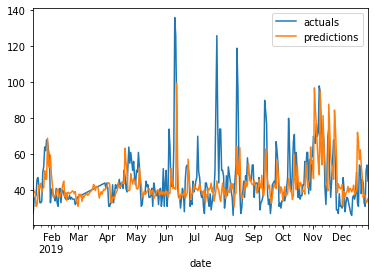

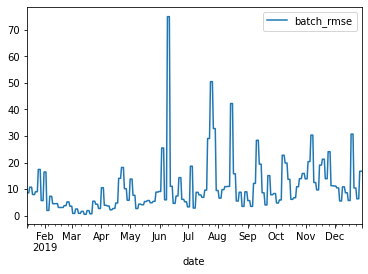

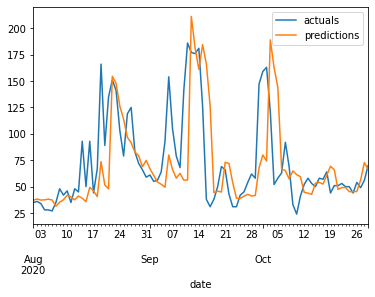

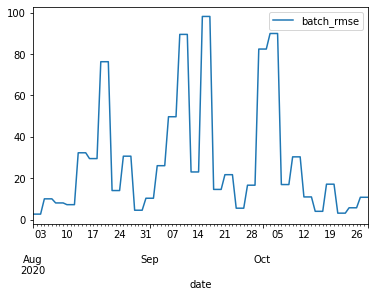

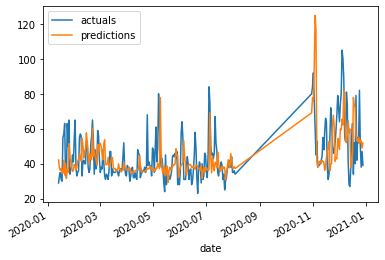

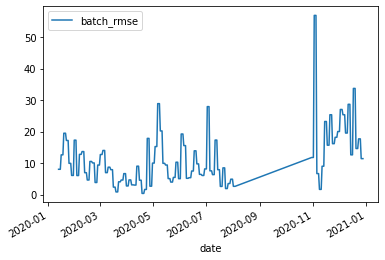

In [ ]:
cv_results(df_cv_lstm_2019)
cv_results(df_cv_lstm_2020_wildfire)
cv_results(df_cv_lstm_2020_non_wildfire)

### Tuning Results
Use this to read in the tuning results csv file since tuning takes a lot of compute.

In [ ]:
def tune_stats(df_tune_summary, epoch_lower, epoch_upper):
    return df_tune_summary[df_tune_summary['epoch'].between(epoch_lower,epoch_upper)].groupby('experiment')[['train_rmse', 'test_rmse']].mean()
    
def tune_plot(df_tune_summary, exp_name, epoch_limit = 100):
    df_tune_summary[(df_tune_summary['experiment'] == exp_name) & (df_tune_summary['epoch'] < epoch_limit)].groupby(['epoch','run']).max()[['train_rmse', 'test_rmse']].unstack().plot(legend = False)
    
def tune_best_stats(df_tune_summary):
    tmp_df = df_tune_summary.groupby(['experiment', 'epoch', 'neurons', 'batch_size', 'lag', 'direct_features', 'nearby_counties', 'nearby_features'])[['train_rmse', 'test_rmse']].mean()
    return tmp_df.loc[tmp_df.groupby(['experiment', 'neurons', 'batch_size', 'lag', 'direct_features', 'nearby_counties', 'nearby_features'])['test_rmse'].idxmin()].reset_index()

In [ ]:
df_tune_summary = pd.DataFrame()
df_summary_import = pd.read_csv('drive/Shareddrives/STATS_207/data/lstm_tuning_results_final.csv')
df_tune_summary = df_summary_import.copy()

In [ ]:
# Table of Tuning Results
tune_best_stats(df_tune_summary)

,experiment,epoch,neurons,batch_size,lag,direct_features,nearby_counties,nearby_features,train_rmse,test_rmse
0,epochs_100_neurons_100_batchsize_1_lag_2_direc...,44,100,1,2,meteor,close,windproject,14.819814,23.335830
1,epochs_100_neurons_10_batchsize_1_lag_14_direc...,58,10,1,14,meteor,close,windproject,16.123308,29.233505
2,epochs_100_neurons_10_batchsize_1_lag_1_direct...,35,10,1,1,meteor,close,windproject,15.790660,25.622923
3,epochs_100_neurons_10_batchsize_1_lag_2_direct...,57,10,1,2,meteor,close,windproject,15.374773,25.591621
4,epochs_100_neurons_10_batchsize_1_lag_3_direct...,42,10,1,3,meteor,close,windproject,15.920217,26.878674
5,epochs_100_neurons_10_batchsize_1_lag_4_direct...,64,10,1,4,meteor,close,windproject,15.419048,25.726428
6,epochs_100_neurons_10_batchsize_1_lag_5_direct...,56,10,1,5,meteor,close,windproject,15.813333,25.215394
7,epochs_100_neurons_10_batchsize_1_lag_7_direct...,67,10,1,7,aqi,none,none,15.739190,25.456723
8,epochs_100_neurons_10_batchsize_1_lag_7_direct...,36,10,1,7,meteor,close,aqi,15.953610,27.161676
9,epochs_100_neurons_10_batchsize_1_lag_7_direct...,54,10,1,7,meteor,close,meteor,15.135102,27.973401


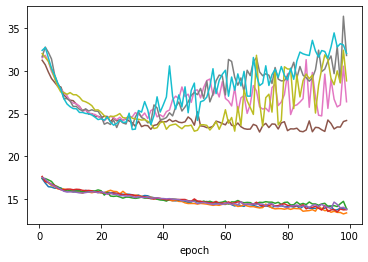

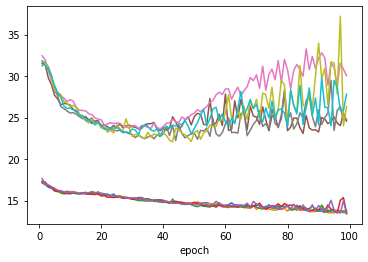

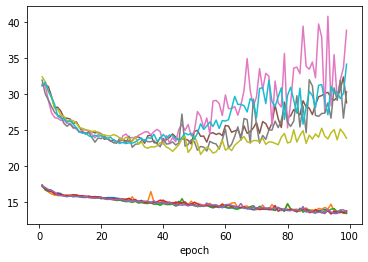

In [ ]:
# Plot of Specific Experiment (Performance at that Config over Epochs)
tune_plot(df_tune_summary, 'epochs_100_neurons_50_batchsize_1_lag_2_directfeatures_meteor_nearcounties_close_nearfeatures_windproject')
tune_plot(df_tune_summary, 'epochs_100_neurons_75_batchsize_1_lag_2_directfeatures_meteor_nearcounties_close_nearfeatures_windproject')
tune_plot(df_tune_summary, 'epochs_100_neurons_100_batchsize_1_lag_2_directfeatures_meteor_nearcounties_close_nearfeatures_windproject')

### Tuning Experiments
Here is the code of all the tuning experiments we ran. These were executed on another computer and stored into a csv file since they take a long time to run.

In [ ]:
def lstm_exp(df_summary, df_master, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 1, 
        direct_features = 'aqi', 
        nearby_counties = 'close',
        nearby_features = 'aqi'
       ):
    for run in range(0, 5):        
        if(direct_features == 'aqi'):
            direct_features_input = ['aqi']
        elif(direct_features == 'meteor'):
            direct_features_input = ['AQI', 
                               'Arithmetic Mean temp', 
                               'Arithmetic Mean rhdp']
        elif(direct_features == 'wind'):
            direct_features_input = ['AQI',
                               'Arithmetic Mean wind_speed', 
                               'Arithmetic Mean wind_direction']
        elif(direct_features == 'meteorwind'):
            direct_features_input = ['AQI', 
                               'Arithmetic Mean temp', 
                               'Arithmetic Mean rhdp',
                               'Arithmetic Mean wind_speed', 
                               'Arithmetic Mean wind_direction']
        elif(direct_features == 'windproject'):
            direct_features_input = ['AQI',
                               'wind_projection']
        elif(direct_features == 'meteorwindproject'):
            direct_features_input = ['AQI', 
                               'Arithmetic Mean temp', 
                               'Arithmetic Mean rhdp',
                               'wind_projection']
        else:
            direct_features_input = ['aqi']

        if(nearby_counties == 'close'):
            nearby_counties_input = close_counties
        else:
            nearby_counties_input = []

        if(nearby_features == 'aqi'):
            nearby_features_input = ['AQI']
        elif(nearby_features == 'meteor'):
            nearby_features_input = ['AQI', 
                               'Arithmetic Mean temp', 
                               'Arithmetic Mean rhdp']
        elif(nearby_features == 'wind'):
            nearby_features_input = ['AQI',
                               'Arithmetic Mean wind_speed', 
                               'Arithmetic Mean wind_direction']
        elif(nearby_features == 'windproject'):
            nearby_features_input = ['AQI',
                               'wind_projection']
        elif(nearby_features == 'meteorwind'):
            nearby_features_input = ['AQI', 
                               'Arithmetic Mean temp', 
                               'Arithmetic Mean rhdp', 
                               'Arithmetic Mean wind_speed', 
                               'Arithmetic Mean wind_direction']
        elif(nearby_features == 'meteorwindproject'):
            nearby_features_input = ['AQI', 
                               'Arithmetic Mean temp', 
                               'Arithmetic Mean rhdp',
                               'wind_projection']
        else:
            nearby_features_input = []

        exp_name = 'epochs_' + str(epochs) + '_neurons_' + str(neurons) + '_batchsize_'+ str(batch_size) + '_lag_' + str(lag) + \
                   '_directfeatures_' + direct_features + '_nearcounties_' + nearby_counties + '_nearfeatures_' + nearby_features

        test_model, test_train, test_test = lstm_tuning(df_master, 
            num_lag = lag, 
            n_ahead = 3,
            batch_size = batch_size, 
            num_epoch = epochs, 
            neurons = neurons, 
            direct_features = direct_features_input, 
            nearby_counties = nearby_counties_input,
            nearby_features = nearby_features_input
           )

        run_df = pd.DataFrame({
            'experiment': exp_name,
            'total_epochs': epochs,
            'neurons': neurons,
            'batch_size': batch_size,
            'lag': lag,
            'direct_features': direct_features,
            'nearby_counties': nearby_counties,
            'nearby_features': nearby_features,
            'run': run,
            'train_rmse': test_train, 
            'test_rmse': test_test}).rename_axis('epoch').reset_index()
        run_df['epoch'] = run_df['epoch'] + 1

        df_summary = pd.concat([df_summary, run_df])
    
    df_summary.to_csv('drive/Shareddrives/STATS_207/data/lstm_tuning_results.csv', index = False)
    
    print('Finished ' + exp_name)
    return df_summary

In [ ]:
df_tuning_set = df_master[df_master['date'] < '2019-01-01']

In [ ]:
# Tune Direct Features
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        num_lag = 7, 
        batch_size = 1, 
        num_epoch = 100, 
        neurons = 10, 
        direct_features = 'aqi', 
        nearby_counties = 'none',
        nearby_features = 'none'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        num_lag = 7, 
        batch_size = 1, 
        num_epoch = 100, 
        neurons = 10, 
        direct_features = 'wind', 
        nearby_counties = 'none',
        nearby_features = 'none'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        num_lag = 7, 
        batch_size = 1, 
        num_epoch = 100, 
        neurons = 10, 
        direct_features = 'meteor', 
        nearby_counties = 'none',
        nearby_features = 'none'
       )

In [ ]:
# Tune Nearby Features
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        num_lag = 7, 
        batch_size = 1, 
        num_epoch = 100, 
        neurons = 10, 
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'aqi'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        num_lag = 7, 
        batch_size = 1, 
        num_epoch = 100, 
        neurons = 10, 
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'wind'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        num_lag = 7, 
        batch_size = 1, 
        num_epoch = 100, 
        neurons = 10, 
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'meteor'
       )

In [ ]:
# Tune Direct Features
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10, 
        direct_features = 'aqi', 
        nearby_counties = 'none',
        nearby_features = 'none'
       )
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10, 
        direct_features = 'windproject', 
        nearby_counties = 'none',
        nearby_features = 'none'
       )
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10, 
        direct_features = 'wind', 
        nearby_counties = 'none',
        nearby_features = 'none'
       )
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10, 
        direct_features = 'meteor', 
        nearby_counties = 'none',
        nearby_features = 'none'
       )
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10, 
        direct_features = 'meteorwind', 
        nearby_counties = 'none',
        nearby_features = 'none'
       )
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10, 
        direct_features = 'meteorwindproject', 
        nearby_counties = 'none',
        nearby_features = 'none'
       )

In [ ]:
# Tune Nearby Features
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'aqi'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'wind'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10, 
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'meteor'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10, 
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10, 
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'meteorwind'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10, 
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'meteorwindproject'
       )

In [ ]:
# Tune Lag
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 1, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 2, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 3, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 4, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 5, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 7, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 14, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 10,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

In [ ]:
# Tune Neurons
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 2, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 1,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 2, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 2,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 2, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 5,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 2, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 20,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 2, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 50,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )
df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 5, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 1,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 5, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 2,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 5, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 5,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 5, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 20,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 5, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 50,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 2, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 75,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

df_tune_summary = lstm_exp(df_tune_summary, df_tuning_set, 
        lag = 2, 
        batch_size = 1, 
        epochs = 100, 
        neurons = 100,  
        direct_features = 'meteor', 
        nearby_counties = 'close',
        nearby_features = 'windproject'
       )

# Hidden Markov Models

In [ ]:
!pip install hmmlearn
from hmmlearn import hmm

     |████████████████████████████████| 374 kB 5.4 MB/s 


In [ ]:
aqi = county_dict['Santa Clara'].AQI
hmm_model = hmm.GaussianHMM(2, "full")
hmm_model.fit(aqi.values.reshape(-1, 1))
labels = hmm_model.predict(aqi.values.reshape(-1, 1)) # separating wildfire from non-wildfire data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

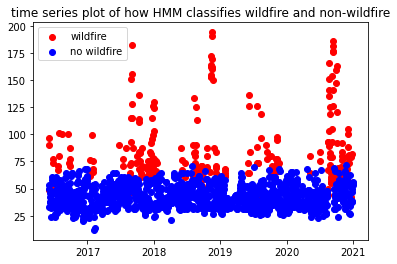

In [ ]:
non_wildfire = aqi[labels==0]
wildfire = aqi[labels==1]
plt.scatter(wildfire.index, wildfire, c = 'red', label = 'wildfire')
plt.scatter(non_wildfire.index, non_wildfire, c = 'blue', label = 'no wildfire')
plt.title('time series plot of how HMM classifies wildfire and non-wildfire')
plt.legend()
from google.colab import files
plt.savefig("hmm.png")
files.download("hmm.png") 
plt.show()

In [ ]:
model_normal = Pipeline([ 
    ('arima',pm.AutoARIMA(trace=True, seasonal=False, error_action='ignore',suppress_warnings=True))
])

## ARIMA Wildfire predictions training only on wildfire AQI

In [ ]:
cv_rolling_idx_wf = cv_rolling_split(wildfire, 30,3,3)
df_summary_normal_wf = cv_rmse(wildfire, cv_rolling_idx_wf, model_normal)

In [ ]:
only_2020 = df_summary_normal_wf[(df_summary_normal_wf['date'] >= '2020-08-01') & (df_summary_normal_wf['date'] <= '2020-10-31')]
only_2020['batch_rmse'].mean() # 35.6

## VARMA Wildfire predictions training only on wildfire AQI

In [ ]:
cv_rolling_idx_wf = cv_rolling_split(wildfire, 50,3,3)
county_varma_df_wf = cv_rmse_VARMA(df_counties[labels == 1], cv_rolling_idx_wf, 'AQI_sc')

In [ ]:
only_2020 = county_varma_df_wf[(county_varma_df_wf['date'] >= '2020-08-01') & (county_varma_df_wf['date'] <= '2020-10-31')]
only_2020['batch_rmse'].mean() # 33.59057193332135

## ARIMA Non-wildfire predictions training only on non-wildfire AQI

In [ ]:
cv_rolling_idx_no_wf = cv_rolling_split(non_wildfire, 30,3,3)
df_summary_normal_no_wf = cv_rmse(non_wildfire, cv_rolling_idx_no_wf, model_normal)

In [ ]:
only_2020 = df_summary_normal_no_wf[(df_summary_normal_no_wf['date'] < '2020-08-01') | (df_summary_normal_no_wf['date'] > '2020-10-31')]
only_2020 = only_2020[only_2020['date'] >= '2020-01-01']
only_2020['batch_rmse'].mean() # 8.8

## VARMA Non-wildfire predictions training only on non-wildfire AQI

In [ ]:
cv_rolling_idx_no_wf = cv_rolling_split(non_wildfire, 150,3,3)
county_varma_df_no_wf = cv_rmse_VARMA(df_counties[labels == 0], cv_rolling_idx_no_wf, 'AQI_sc')

In [ ]:
only_2020 = county_varma_df_no_wf[(county_varma_df_no_wf['date'] < '2020-08-01') | (county_varma_df_no_wf['date'] > '2020-10-31')]
only_2020 = only_2020[only_2020['date'] >= '2020-01-01']
only_2020['batch_rmse'].mean() # 7.840017911013441

# Appendix

## LSTM V2 Tuning

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
              names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
              names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, scaled_dataset, scaler, batch_size, n_ahead):
    # predict
    X, y = scaled_dataset[:, :-n_ahead], scaled_dataset[:, -n_ahead:]
    X_reshaped = X.reshape(1, 1, X.shape[0]) if len(X.shape) == 1 else X.reshape(X.shape[0], 1, X.shape[1])
    y_reshaped = y.reshape(1, n_ahead) if len(y.shape) == 1 else y.reshape(y.shape[0], n_ahead)
    yhat = model.predict(X_reshaped, batch_size=batch_size)
    
    # invert scaling
    predictions = invert_scale(scaler, X, yhat)
    actuals = invert_scale(scaler, X, y_reshaped)
        
    rmse = sqrt(mse(predictions, actuals))
    
    return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, scaler, batch_size, nb_epoch, neurons, n_ahead, tune = True):
    X, y = train[:, 0:-n_ahead], train[:, -n_ahead:]
    X = X.reshape(1, 1, X.shape[0]) if len(X.shape) == 1 else X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mae', optimizer='adam')
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        if tune:
            train_rmse.append(evaluate(model, 
                                       train, 
                                       scaler, 
                                       batch_size,
                                       n_ahead = n_ahead))
    #         model.reset_states()
            test_rmse.append(evaluate(model, 
                                      test, 
                                      scaler, 
                                      batch_size,
                                      n_ahead = n_ahead))
    #         model.reset_states()
    
    if tune:
        return model, train_rmse, test_rmse
    else:
        return model

# Update LSTM model
def update_model(model, train, batch_size, updates, n_ahead):
    X, y = train[:, 0:-n_ahead], train[:, -n_ahead:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    for i in range(updates):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    if(len(X.shape) == 1):
        X = X.reshape(1, 1, X.shape[0])
    else:
        X = X.reshape(X.shape[0], 1, X.shape[1])
    yhat = model.predict(X, batch_size=batch_size)
    return yhat

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
#     new_row = [x for x in X] + [yhat]
#     array = np.array(new_row)
#     array = array.reshape(1, len(array))
#     inverted = scaler.inverse_transform(array)
    n_ahead = yhat.shape[0] if len(yhat.shape) == 1 else yhat.shape[1]
    X = [X] if len(X.shape) == 1 else X
    array = np.concatenate((X, yhat), axis=1)
    inverted = scaler.inverse_transform(array)
    return inverted[:, -n_ahead:]

def lstm_tuning(df_master, 
                num_lag = 7,
                n_ahead = 1,
                batch_size = 1, 
                num_epoch = 50, 
                neurons = 50, 
                direct_features = None, 
                nearby_counties = [], 
                nearby_features = []):
    # Process the lagged features into a nice matrix
    if(direct_features == None):
        direct_features = ['AQI'] # AQI must be the first

    # Convert Santa Clara series into input matrix
    df_lstm_input = series_to_supervised(df_master[df_master['County Name'] == 'Santa Clara'].set_index(['date', 'County Name']), n_in = num_lag, n_out = n_ahead)
    # remove current t and future t variables except for our Y prediction
    df_lstm_input.drop(columns=df_lstm_input.filter(regex='[^1]\(t\+?\d*\)').columns, inplace=True)
    df_lstm_input.columns = df_lstm_input.columns.str.replace("var", "var0_")
    df_lstm_input.reset_index(inplace = True)

    # Add in features of nearby counties
    i = 1 # incremental index to prefix the variables for different counties
    for c in nearby_counties:
        if (c != 'Santa Clara') & (len(df_master[df_master['County Name'] == c]) > 0):
            df_shaped = series_to_supervised(df_master[df_master['County Name'] == c].set_index(['date', 'County Name'])[nearby_features].dropna(axis='columns'), n_in = num_lag, n_out = n_ahead)
            # remove all columns after time t, since we only use past values for these reference time series
            df_shaped.drop(columns=df_shaped.filter(regex='\(t\+?\d*\)').columns, inplace=True)
            df_shaped.reset_index(inplace=True)
            df_shaped.drop(columns='County Name', inplace = True)
            df_shaped.columns = df_shaped.columns.str.replace("var", "var" + str(i) + "_")
            df_lstm_input = df_lstm_input.merge(df_shaped, on='date', how='left')
            i = i + 1

    df_lstm_input.drop(columns='County Name', inplace = True)
    df_lstm_input.set_index('date', inplace = True)
    df_lstm_input['var0_1(t)'] = df_lstm_input.pop('var0_1(t)') # move Y column to the last column
    for n in range(1, n_ahead): # repeat for other Y values
        df_lstm_input['var0_1(t+' + str(n) + ')'] = df_lstm_input.pop('var0_1(t+' + str(n) + ')')

    # split into fixed training and CV section
#     df_lstm_no_update = df_lstm_input[df_lstm_input.index < '2020-01-01']
    df_lstm_no_update = df_lstm_input

    # scaled factors
    scaler = MinMaxScaler(feature_range=(0, 1))

    # fit the scaler on the fixed training data
    scaler = scaler.fit(df_lstm_no_update)
    # scale the training data
    df_lstm_no_update_scaled = scaler.transform(df_lstm_no_update)

    # fill na
#     df_lstm_no_update_scaled = pd.DataFrame(data=df_lstm_no_update_scaled).fillna(0).values
#     df_lstm_cv_scaled = pd.DataFrame(data=df_lstm_cv_scaled).fillna(0).values
    
    # fit base model
    base_model, train_rmse, test_rmse = fit_lstm(
        train=df_lstm_no_update_scaled[0:(floor(len(df_lstm_no_update_scaled)*0.8)),:], 
        test=df_lstm_no_update_scaled[(floor(len(df_lstm_no_update_scaled)*0.8)+1):,:],
        scaler = scaler,
        batch_size = batch_size, 
        nb_epoch = num_epoch, 
        neurons = neurons,
        n_ahead = n_ahead)
    
    print("Base Model Fitted")
    
    return base_model, train_rmse, test_rmse
  
def lstm_cv(df_master, 
          num_lag = 7,
          n_ahead = 1,
          batch_size = 1, 
          num_epoch = 50, 
          neurons = 50, 
          direct_features = None, 
          nearby_counties = [], 
          nearby_features = [],
          cv_cutoff_date = '2019-09-15'):
  
  # Process the lagged features into a nice matrix
  if(direct_features == None):
      direct_features = ['AQI'] # AQI must be the first

  # Convert Santa Clara series into input matrix
  df_lstm_input = series_to_supervised(df_master[df_master['County Name'] == 'Santa Clara'].set_index(['date', 'County Name']), n_in = num_lag, n_out = n_ahead)
  # remove current t and future t variables except for our Y prediction
  df_lstm_input.drop(columns=df_lstm_input.filter(regex='[^1]\(t\+?\d*\)').columns, inplace=True)
  df_lstm_input.columns = df_lstm_input.columns.str.replace("var", "var0_")
  df_lstm_input.reset_index(inplace = True)

  # Add in features of nearby counties
  i = 1 # incremental index to prefix the variables for different counties
  for c in nearby_counties:
      if (c != 'Santa Clara') & (len(df_master[df_master['County Name'] == c]) > 0):
          df_shaped = series_to_supervised(df_master[df_master['County Name'] == c].set_index(['date', 'County Name'])[nearby_features].dropna(axis='columns'), n_in = num_lag, n_out = n_ahead)
          # remove all columns after time t, since we only use past values for these reference time series
          df_shaped.drop(columns=df_shaped.filter(regex='\(t\+?\d*\)').columns, inplace=True)
          df_shaped.reset_index(inplace=True)
          df_shaped.drop(columns='County Name', inplace = True)
          df_shaped.columns = df_shaped.columns.str.replace("var", "var" + str(i) + "_")
          df_lstm_input = df_lstm_input.merge(df_shaped, on='date', how='left')
          i = i + 1

  df_lstm_input.drop(columns='County Name', inplace = True)
  df_lstm_input.set_index('date', inplace = True)
  df_lstm_input['var0_1(t)'] = df_lstm_input.pop('var0_1(t)') # move Y column to the last column
  for n in range(1, n_ahead): # repeat for other Y values
      df_lstm_input['var0_1(t+' + str(n) + ')'] = df_lstm_input.pop('var0_1(t+' + str(n) + ')')
      
  # split into fixed training and CV section
  df_lstm_fixed = df_lstm_input[df_lstm_input.index < cv_cutoff_date]
  df_lstm_cv = df_lstm_input[df_lstm_input.index >= cv_cutoff_date]

  # scaled factors
  scaler = MinMaxScaler(feature_range=(0, 1))

  # fit the scaler on the fixed training data
  scaler = scaler.fit(df_lstm_fixed)
  # scale the training data
  df_lstm_fixed_scaled = scaler.transform(df_lstm_fixed)

  # scale the cv data
  df_lstm_cv_scaled = scaler.transform(df_lstm_cv)

  # fill na
  df_lstm_fixed_scaled = pd.DataFrame(data=df_lstm_fixed_scaled).fillna(0).values
  df_lstm_cv_scaled = pd.DataFrame(data=df_lstm_cv_scaled).fillna(0).values

  # fit base model
  base_model = fit_lstm(
      train=df_lstm_fixed_scaled,
      test=pd.DataFrame(), # empty df
      scaler = scaler,
      batch_size = batch_size, 
      nb_epoch = num_epoch, 
      neurons = neurons,
      n_ahead = n_ahead,
      tune = False)

  train_rmse, test_rmse = list(), list()
  
  # Cross Validation
  cv_rolling_idx = cv_rolling_split(df_lstm_cv_scaled, 120, 3, 3)

#     cv_rmse = list()
  
  df_cv_summary = pd.DataFrame()
  batch_num = 0
  
  for cv_batch in cv_rolling_idx:
      cv_train = df_lstm_cv_scaled[cv_batch[0], :]
      cv_test = df_lstm_cv_scaled[cv_batch[1], :]
      
      # get batch info
      batch_train_min_date = min(df_lstm_cv.reset_index().iloc[cv_batch[0], :]['date'])
      batch_train_max_date = max(df_lstm_cv.reset_index().iloc[cv_batch[0], :]['date'])
      batch_test_min_date = min(df_lstm_cv.reset_index().iloc[cv_batch[1], :]['date'])
      batch_test_max_date = max(df_lstm_cv.reset_index().iloc[cv_batch[1], :]['date'])

      # make a copy of base model and do incremental update on the cv batch
      cv_model = clone_model(base_model)
      cv_model.compile(loss='mae', optimizer='adam')
      cv_model.set_weights(base_model.get_weights())
      update_model(cv_model, cv_train, batch_size=1, updates=3, n_ahead = n_ahead)

      # forecast test dataset
      track = 0

#         for i in range(len(cv_test)):
      # predict
      cv_test_X, cv_test_y = cv_test[0, :-n_ahead], cv_test[0, -n_ahead:]
      cv_test_y = cv_test_y.reshape(1, n_ahead) # only doing 1 prediction, so first value is 1
      yhat = forecast_lstm(model = cv_model, batch_size = 1, X = cv_test_X)

      # invert scaling
      predictions = invert_scale(scaler, cv_test_X, yhat)[0]
      actuals = invert_scale(scaler, cv_test_X, cv_test_y)[0]

      # pull test_date from original df
      test_dates = df_lstm_cv.reset_index().iloc[cv_batch[1], :]['date']

      # calculate RMSE
#         cv_rmse.append(sqrt(mse(predictions, actuals)))
      
      # append to df
      batch_df = pd.DataFrame({
          'cv_batch': batch_num,
          'batch_train_min_date': batch_train_min_date,
          'batch_train_max_date': batch_train_max_date,
          'batch_test_min_date': batch_test_min_date,
          'batch_test_max_date': batch_test_max_date,
          'batch_rmse': sqrt(mse(predictions, actuals)),
          'date': test_dates,
          'predictions': predictions,
          'actuals': actuals,
      })
      df_cv_summary = pd.concat([df_cv_summary, batch_df])
      
      batch_num = batch_num + 1

  return base_model, df_cv_summary

See https://docs.google.com/spreadsheets/d/1489mjUYb8jzJwy-p1kVoCM576sNkdUHXKNqjU4bjbFs/edit#gid=0 for configurations tested

In [ ]:
# Sample Tuning Run
df_tune_summary = pd.DataFrame()

for run in range(0, 5):
    exp_name = 'epoch500_neuron1_batch1_lag7_nearby_wind'
    test_model, test_train, test_test = lstm_tuning(df_master, 
        num_lag = 7, 
        n_ahead = 1,
        batch_size = 1, 
        num_epoch = 500, 
        neurons = 1, 
        direct_features = ['AQI', 
                           'Arithmetic Mean temp', 
                           'Arithmetic Mean rhdp', 
                           'Arithmetic Mean wind_speed', 
                           'Arithmetic Mean wind_direction', 
                           'wind_projection'], 
        nearby_counties = close_counties,
        nearby_features = ['AQI', 
                           'wind_projection']
       )

    run_df = pd.DataFrame({
        'experiment': exp_name,
        'run': run,
        'train_rmse': test_train, 
        'test_rmse': test_test}).rename_axis('epoch').reset_index()
    run_df['epoch'] = run_df['epoch'] + 1

    df_tune_summary = pd.concat([df_tune_summary, run_df])

KeyboardInterrupt: ignored

## LSTM Tuning Read/Write

Read and Write results since takes long to run

In [ ]:
df_tune_summary.to_csv('drive/Shareddrives/STATS_207/data/lstm_tuning_results.csv', index = False)

In [ ]:
df_summary_import = pd.read_csv('drive/Shareddrives/STATS_207/data/lstm_tuning_results.csv')

In [ ]:
df_tune_summary = df_summary_import.copy()

In [ ]:
# summary RMSE of experiments
df_tune_summary[df_tune_summary['epoch'].between(60,70)].groupby('experiment')[['train_rmse', 'test_rmse']].mean()

In [ ]:
# rmse plot for single experiment
df_tune_summary[(df_tune_summary['experiment'] == 'epoch100_neuron10_batch1_lag7_nearby_wind') & (df_tune_summary['epoch'] < 150)].groupby(['epoch','run']).max()[['train_rmse', 'test_rmse']].unstack().plot(legend = False)

## LSTM CV Run

In [ ]:
# # sample cv run
cv_base_model_2020, df_cv_summary_2020 = lstm_cv(df_master, 
        num_lag = 2, 
        n_ahead = 3,
        batch_size = 1, 
        num_epoch = 30, 
        neurons = 10, 
        direct_features = ['AQI', 
                           'Arithmetic Mean temp', 
                           'Arithmetic Mean rhdp', 
                           'Arithmetic Mean wind_speed', 
                           'Arithmetic Mean wind_direction', 
                           'wind_projection'], 
        nearby_counties = close_counties,
        nearby_features = ['AQI', 
                           'wind_projection'],
        cv_cutoff_date = '2019-09-15')




In [ ]:
# sample cv run
cv_base_model_2019, df_cv_summary_2019 = lstm_cv(df_master, 
        num_lag = 2, 
        n_ahead = 3,
        batch_size = 1, 
        num_epoch = 30, 
        neurons = 10, 
        direct_features = ['AQI', 
                           'Arithmetic Mean temp', 
                           'Arithmetic Mean rhdp', 
                           'Arithmetic Mean wind_speed', 
                           'Arithmetic Mean wind_direction', 
                           'wind_projection'], 
        nearby_counties = close_counties,
        nearby_features = ['AQI', 
                           'wind_projection'],
        cv_cutoff_date = '2018-09-15')

In [ ]:
#df_cv_lstm_2019 = df_cv_summary_2019[(df_cv_summary_2019['batch_test_min_date'] >= '2019-01-01') & (df_cv_summary_2019['batch_test_max_date'] <= '2019-12-31')]
df_cv_lstm_2020_wildfire = df_cv_summary_2020[(df_cv_summary_2020['batch_test_min_date'] >= '2020-08-01') & (df_cv_summary_2020['batch_test_max_date'] <= '2020-10-31')]
df_cv_lstm_2020_non_wildfire = df_cv_summary_2020[(df_cv_summary_2020['batch_test_min_date'] <= '2020-08-01') | (df_cv_summary_2020['batch_test_max_date'] >= '2020-10-31')]

In [ ]:
def cv_results(df):
  print(df.groupby('cv_batch').max('batch_rmse')['batch_rmse'].mean())
  # print(sqrt(mse(df['actuals'], df['predictions'])))
  df.plot(x='date', y = ['actuals','predictions'])
  df.plot(x='date', y = 'batch_rmse')

28.919025183123672
10.404387573906392


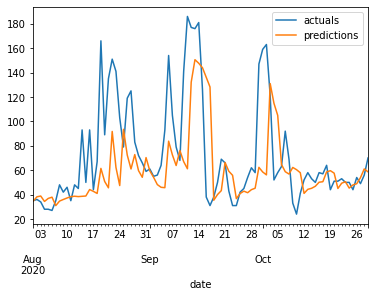

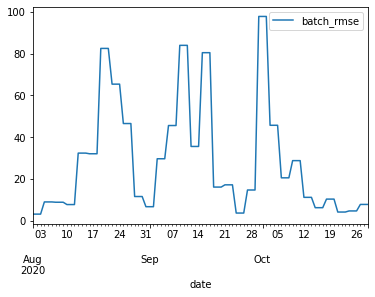

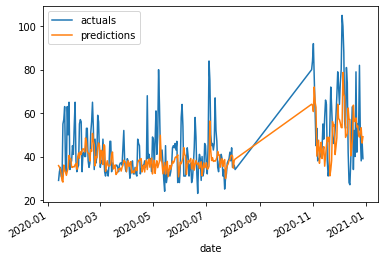

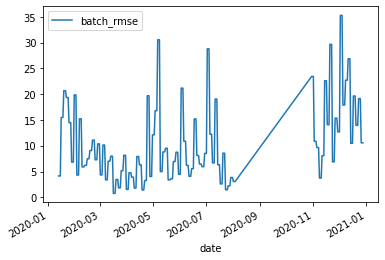

In [ ]:
# cv_results(df_cv_lstm_2019)
cv_results(df_cv_lstm_2020_wildfire)
cv_results(df_cv_lstm_2020_non_wildfire)

## LSTM V1
Added CV

In [ ]:
# multivariate lagged df
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
              names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
              names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [ ]:
# Process the lagged features into a nice matrix
num_lag = 7
nearby_counties = close_counties
nearby_features = ['AQI', 'wind_projection']

df_lstm_input = series_to_supervised(df_master[df_master['County Name'] == 'Santa Clara'].set_index(['date', 'County Name']), n_in = num_lag, n_out = 1)
# remove current t and future t variables except for our Y prediction
df_lstm_input.drop(columns=df_lstm_input.filter(regex='[^1]\(t\+?\d*\)').columns, inplace=True)
df_lstm_input.columns = df_lstm_input.columns.str.replace("var", "var0_")
df_lstm_input.reset_index(inplace = True)
i = 1
for c in nearby_counties:
    if c != 'Santa Clara':
        df_shaped = series_to_supervised(df_master[df_master['County Name'] == c].set_index(['date', 'County Name'])[nearby_features], n_in = num_lag, n_out = 1)
        # remove all columns after time t, since we only use past values for these reference time series
        df_shaped.drop(columns=df_shaped.filter(regex='\(t\+?\d*\)').columns, inplace=True)
        df_shaped.reset_index(inplace=True)
        df_shaped.drop(columns='County Name', inplace = True)
        df_shaped.columns = df_shaped.columns.str.replace("var", "var" + str(i) + "_")
        df_lstm_input = df_lstm_input.merge(df_shaped, on='date', how='left')
        i = i + 1
        
df_lstm_input.drop(columns='County Name', inplace = True)
df_lstm_input.set_index('date', inplace = True)
df_lstm_input['var0_1(t)'] = df_lstm_input.pop('var0_1(t)')

In [ ]:
# split into fixed training and CV section
df_lstm_no_update = df_lstm_input[df_lstm_input.index < '2020-01-01']
df_lstm_cv = df_lstm_input[df_lstm_input.index >= '2020-01-01']

In [ ]:
# scaled factors
scaler = MinMaxScaler(feature_range=(0, 1))

# fit the scaler on the fixed training data
scaler = scaler.fit(df_lstm_no_update)
# scale the training data
df_lstm_no_update_scaled = scaler.transform(df_lstm_no_update)

# scale the cv data
df_lstm_cv_scaled = scaler.transform(df_lstm_cv)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [ ]:
# fill na
df_lstm_no_update_scaled = pd.DataFrame(data=df_lstm_no_update_scaled).fillna(0).values
df_lstm_cv_scaled = pd.DataFrame(data=df_lstm_cv_scaled).fillna(0).values

In [ ]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# Update LSTM model
def update_model(model, train, batch_size, updates):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    for i in range(updates):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [ ]:
base_model = fit_lstm(df_lstm_no_update_scaled, batch_size=1, nb_epoch=50, neurons=50)

1302/1302 [==============================] - 3s 2ms/step - loss: 0.0455


In [ ]:
# Cross Validation
cv_rolling_idx = cv_rolling_split(df_lstm_cv_scaled, 120, 6, 6)

cv_rmse = list()

for cv_batch in cv_rolling_idx:
    cv_train = df_lstm_cv_scaled[cv_batch[0], :]
    cv_test = df_lstm_cv_scaled[cv_batch[1], :]

    cv_model = clone_model(base_model)
    cv_model.compile(loss='mae', optimizer='adam')
    cv_model.set_weights(base_model.get_weights())

    update_model(cv_model, cv_train, batch_size=1, updates=3)

    # forecast test dataset
    predictions = list()
    actuals = list()
    track = 0
    for i in range(len(cv_test)):
        # predict
        cv_test_X, cv_test_y = cv_test[i, :-1], cv_test[i, -1]
        yhat = forecast_lstm(cv_model, 1, cv_test_X)

        # invert scaling
        yhat = invert_scale(scaler, cv_test_X, yhat)
        predictions.append(yhat)
        actuals.append(invert_scale(scaler, cv_test_X, cv_test_y))

    # calculate RMSE
    cv_rmse.append(sqrt(mse(predictions, actuals)))

In [ ]:
np.mean(cv_rmse)

16.91148921794577

## LSTM V0

In [ ]:
# scaled factors
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_input = min_max_scaler.fit_transform(df_lstm_input)

In [ ]:
# fill na
df_lstm_input = pd.DataFrame(data=df_lstm_input).fillna(0).values

In [ ]:
# split into train and test sets
n_train = 365 * 2
train = df_lstm_input[:n_train, :]
test = df_lstm_input[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(730, 1, 1386) (730,) (938, 1, 1386) (938,)


Epoch 1/50
105/105 - 3s - loss: 0.1015 - val_loss: 0.0847 - 3s/epoch - 28ms/step
Epoch 2/50
105/105 - 0s - loss: 0.0651 - val_loss: 0.0858 - 498ms/epoch - 5ms/step
Epoch 3/50
105/105 - 1s - loss: 0.0640 - val_loss: 0.0766 - 516ms/epoch - 5ms/step
Epoch 4/50
105/105 - 1s - loss: 0.0626 - val_loss: 0.0770 - 657ms/epoch - 6ms/step
Epoch 5/50
105/105 - 1s - loss: 0.0616 - val_loss: 0.0747 - 506ms/epoch - 5ms/step
Epoch 6/50
105/105 - 1s - loss: 0.0596 - val_loss: 0.0733 - 527ms/epoch - 5ms/step
Epoch 7/50
105/105 - 0s - loss: 0.0598 - val_loss: 0.0753 - 497ms/epoch - 5ms/step
Epoch 8/50
105/105 - 0s - loss: 0.0584 - val_loss: 0.0757 - 495ms/epoch - 5ms/step
Epoch 9/50
105/105 - 1s - loss: 0.0583 - val_loss: 0.0838 - 503ms/epoch - 5ms/step
Epoch 10/50
105/105 - 0s - loss: 0.0585 - val_loss: 0.0919 - 495ms/epoch - 5ms/step
Epoch 11/50
105/105 - 0s - loss: 0.0586 - val_loss: 0.0953 - 472ms/epoch - 4ms/step
Epoch 12/50
105/105 - 1s - loss: 0.0585 - val_loss: 0.0760 - 622ms/epoch - 6ms/step
Epo

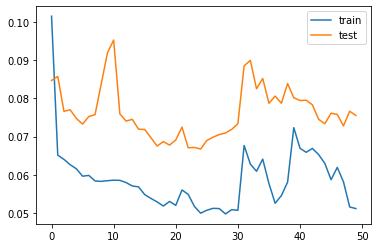

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=7, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X_shaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((test_X_shaped, yhat), axis=1)
inv_yhat = min_max_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y_shaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X_shaped, test_y_shaped), axis=1)
inv_y = min_max_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mse(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.251


## HMM

In [ ]:
!pip install hmmlearn
from hmmlearn import hmm


     |████████████████████████████████| 374 kB 4.2 MB/s 


In [ ]:
hmm_model = hmm.GaussianHMM(2, "full")
hmm_model.fit(aqi.values.reshape(-1, 1))
labels = hmm_model.predict(aqi.values.reshape(-1, 1))

In [ ]:
non_wildfire = aqi[labels==0]
wildfire = aqi[labels==1]

In [ ]:
model_normal = Pipeline([ 
    ('arima',pm.AutoARIMA(trace=True, seasonal=False, error_action='ignore',suppress_warnings=True))
])

In [ ]:
cv_rolling_idx_wf = cv_rolling_split(wildfire, 30,3,3)
df_summary_normal_wf = cv_rmse(wildfire, cv_rolling_idx_wf, model_normal)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=347.683, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=267.798, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=269.705, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=253.353, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=252.646, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=250.242, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=250.465, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.018 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,

In [ ]:
only_2020 = df_summary_normal_wf[(df_summary_normal_wf['date'] >= '2020-08-01') & (df_summary_normal_wf['date'] <= '2020-10-31')]
only_2020['batch_rmse'].mean()

37.97615423950877

In [ ]:
cv_rolling_idx_no_wf = cv_rolling_split(non_wildfire, 30,3,3)
df_summary_normal_no_wf = cv_rmse(non_wildfire, cv_rolling_idx_no_wf, model_normal)


Streaming output truncated to the last 5000 lines.
Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.692 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=310.849, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=205.854, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=205.043, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=203.315, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=204.657, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=195.259, Time=0.12 sec
 ARIMA(0,0,2)

In [ ]:
only_2020 = df_summary_normal_no_wf[(df_summary_normal_no_wf['date'] < '2020-08-01') | (df_summary_normal_no_wf['date'] > '2020-10-31')]
only_2020 = only_2020[only_2020['date'] >= '2020-01-01']
only_2020['batch_rmse'].mean()

8.799820037772564